In [1]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
import pickle
import time
import random
from collections import Counter

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif,chi2, mutual_info_classif, VarianceThreshold, RFE, SelectFromModel

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier#, GradientBoostingClassifier, ExtraTreesClassifier

import matplotlib.pyplot as plt
import python_files.functions_barcelona_Correlations as fb3

%load_ext autoreload
%autoreload 2

In [14]:
accidents=pd.read_csv('./data/accidents_weather_eng_2023.csv')
def creating_target(row):
    return 1 if row['num_deaths']+row['num_severly_injured']>0 else 0
accidents['target']=accidents.apply(creating_target,axis=1)


cat_columns=[]
num_columns=[]
to_drop=['index','num_incident', 'num_severly_injured','num_deaths',\
         'num_minorly_injured','num_victims','street_code', 'dates','datetimes','utm_x','utm_y','district_code']
for col in accidents:
    if 'Unnamed' in col:
        accidents=accidents.drop(col,axis=1)
for col in accidents.columns:
    if col in to_drop:
        accidents=accidents.drop(col,axis=1)
    elif 'bins' in col:
        cat_columns.append(col)
    elif ('vehicle_' in col): 
        cat_columns.append(col)
    elif 'seniority' in col:
        num_columns.append(col)
    elif 'license' in col:
        pass #license is discarded due to the fact that the information it provides is already 
        # contained in vehicles
    elif col =='target':
        pass
    elif 'num' in col or '_count' in col:
        num_columns.append(col)
    elif accidents[col].nunique()<76:
        cat_columns.append(col)
    elif accidents[col].dtypes==float:
        num_columns.append(col)
len(cat_columns),len(num_columns),len(accidents.columns),len(accidents.columns)-len(cat_columns)-len(num_columns)

(34, 15, 53, 4)

In [3]:
pending=[x for x in accidents.columns if x not in cat_columns+num_columns]
for col in pending:
    print(col,accidents[col].dtypes, accidents[col].nunique())

street_name object 9312
license object 1506
datetime object 67652
target int64 2


<a id='start'></a>

# Selecting Features:
1. [**Numerical Features**.](#num_fea)
    - [FILTER: Variance Threashold.](#num_vt) Univariate features are eliminated
    - [FILTER: ANOVA](#anova)
    - [FILTER: Pearson, Kendall, Spearman Correlation.](#num_corr)
    - [FILTER: Information Gain.](#inf_gain)
    - [WRAPPER: Recursive Feature Elimination.](#num_rfe)
    - [EMBEDDED: RandomForestClassifier](#num_rf)
    - [EMBEDDED: Lasso.](#num_lasso)
3. [**Categorical Features**.](#cat_fea)
    - [FILTER: Variance Threashold.](#cat_vt)
    - [FILTER: Chi Square and Mutual Information](#chi_sq)
    - [FILTER: Cramer's V, Theil's U Correlation.](#cat_corr)
    - [FILTER: Mutual Information/Information Gain.](#mut_info)
    - [WRAPPER: Recursive Feature Elimination.](#cat_rfe)
    - [EMBEDDED: RandomForestClassifier](#cat_rf)
    - [EMBEDDED: Lasso.](#cat_lasso)
5. Analysis Selected Features. In the case of the num_features, it looks like if the method used is based on eliminating features or it is a filter method we end up choosing the same 3.

<a id='num_fea'></a>
1. **Numerical Features**.

[back top](#start)

In [15]:
correlations= abs(accidents[num_columns].corr())
correlations=correlations.replace(1,0)
for col in num_columns:
    #print(correlations[col])
    if correlations[col].max()>0.8:
        print(col, round(correlations[col].max(),2),correlations[col].sort_values(ascending=False).index[0])
        num_columns.remove(correlations[col].sort_values(ascending=False).index[0])
num_columns

temp_avg 1.0 temp_min
temp_max 1.0 temp_avg
windspeed 0.87 max_windspeed


['num_vehicles',
 'age_driver',
 'license_seniority',
 'temp_max',
 'relative_humidity',
 'precipitation',
 'windspeed',
 'wind_direction',
 'pressure',
 'solar_radiation',
 'street_name_count',
 'neighborhood_count']

In [9]:
correlations= abs(accidents[num_columns].corr())
correlations=correlations.replace(1,0)
for col in num_columns:
    #print(correlations[col])
    if correlations[col].max()>0.8:
        print(col, round(correlations[col].max(),2),correlations[col].sort_values(ascending=False).index[0])
#They are strongly correlated therefore I eliminate temp_min,temp_max and max_windspeed
to_remove=['temp_min','temp_max','max_windspeed']
for col in to_remove:
    if col in num_columns:
        num_columns.remove(col)
num_columns

temp_avg 1.0 temp_min
temp_max 1.0 temp_avg
temp_min 1.0 temp_avg
windspeed 0.87 max_windspeed
max_windspeed 0.87 windspeed


['num_vehicles',
 'age_driver',
 'license_seniority',
 'temp_avg',
 'relative_humidity',
 'precipitation',
 'windspeed',
 'wind_direction',
 'pressure',
 'solar_radiation',
 'street_name_count',
 'neighborhood_count']

In [16]:
#To avoid further problems when using ordinal encoder. I decided to go to a classic train_test split
X_train_num, X_test_num, y_train, y_test=train_test_split(accidents[num_columns],accidents.target,test_size=0.1) 

<a id='num_vt'></a>
1. **Numerical Features**.
    - FILTER: Variance Threashold.
   
[back top](#start)

In [17]:
vt=VarianceThreshold()
vt.fit(X_train_num)
[num_columns[col[0]] for col in enumerate(vt.get_support()) if  not col[1]]
 ##=======>>No changes

[]

<a id='anova'></a>
1. **Numerical Features**.
    - FILTER: ANOVA.
   
[back top](#start)

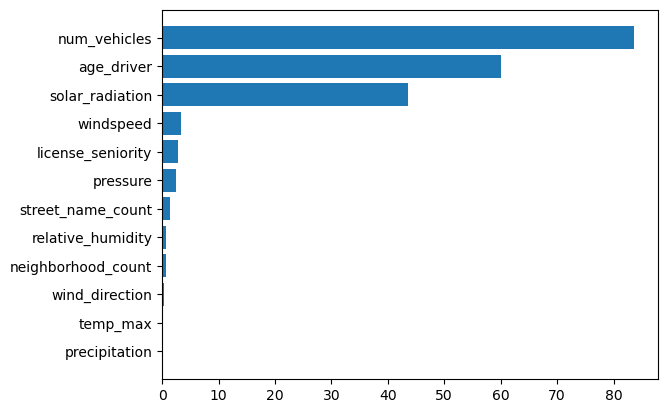

In [18]:
numerical_chosen=[]
def select_features(X_train, y_train, X_test,score_func=f_classif):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_num, y_train, X_test_num)
# what are scores for the features
sorted_columns=sorted([x for x in zip(num_columns,fs.scores_)], key=lambda x: x[1],reverse=True)
anova_sel=[col[0] for col in sorted_columns[:5]]
numerical_chosen.extend(anova_sel)
# for i in range(len(sorted_columns)):
#     print(f'Feature {sorted_columns[i][0]}:{sorted_columns[i][1]}')
# plot the scores
cols=[a for a,b in sorted_columns]
scores=[b for a,b in sorted_columns]
plt.barh(cols[::-1], scores[::-1])
plt.show()

<a id='num_corr'></a>
1. **Numerical Features**.
    - FILTER: Pearson, Kendall and Spearman Correlations.
   
[back top](#start)

In [19]:
pearson_sel=list(abs(accidents[num_columns +['target']].corr()['target']).sort_values(ascending=False)[1:4].index)
print('Pearson Selection: ','\n',pearson_sel)
numerical_chosen.extend(pearson_sel)
kendall_sel=list(abs(accidents[num_columns +['target']].corr(method='kendall')['target']).sort_values(ascending=False)[1:4].index)
numerical_chosen.extend(kendall_sel)
print('Kendall Selection: ','\n',kendall_sel)
spearman_sel=list(abs(accidents[num_columns +['target']].corr(method='spearman')['target']).sort_values(ascending=False)[1:4].index)
numerical_chosen.extend(spearman_sel)
print('Spearman Selection: ','\n',spearman_sel)

Pearson Selection:  
 ['num_vehicles', 'age_driver', 'solar_radiation']
Kendall Selection:  
 ['num_vehicles', 'solar_radiation', 'age_driver']
Spearman Selection:  
 ['num_vehicles', 'solar_radiation', 'age_driver']


<a id='inf_gain'></a>
1. **Numerical Features**.
    - FILTER: Information Gain.
   
[back top](#start)

In [20]:
importances=mutual_info_classif(X_train_num, y_train)
info_gain_sel=list(pd.DataFrame(importances,columns=['InformationGain'],index=num_columns).sort_values('InformationGain',ascending=False).index[:3])
numerical_chosen.extend(info_gain_sel)
info_gain_sel

['num_vehicles', 'neighborhood_count', 'age_driver']

<a id='num_rfe'></a>
1. **Numerical Features**.
    - WRAPPER: Recursive Feature Elimination.
   
[back top](#start)

In [21]:
lr=LogisticRegression()
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train_num)
X_test_minmax=min_max_scaler.transform(X_test_num)
for n_cols in range(1,X_train_num.shape[1]):

    rfe=RFE(lr,n_features_to_select=n_cols)
    rfe.fit(X_train_minmax,y_train)
    #print([num_columns[x[0]] for x in enumerate(rfe.ranking_) if x[1]==1])
rfe=RFE(lr,n_features_to_select=3)
rfe.fit(X_train_minmax,y_train)
rfe_sel=[num_columns[x[0]] for x in enumerate(rfe.ranking_) if x[1]==1]
numerical_chosen.extend(rfe_sel)
print('Three Selected by RFE: ','\n', rfe_sel)

Three Selected by RFE:  
 ['num_vehicles', 'age_driver', 'solar_radiation']


<a id='num_rf'></a>
1. **Numerical Features**.
    - EMBEDDED: Random Forest Classifier.
   
[back top](#start)

In [22]:
rf=RandomForestClassifier(n_estimators=100, random_state=2024)
rf.fit(X_train_num,y_train)
rf_sel=sorted([x[0] for x in zip(num_columns,rf.feature_importances_)],key=lambda x:x[1],reverse=True)[:3]
numerical_chosen.extend(rf_sel)
print('Three Selected by RandomForest: ','\n', rf_sel)

Three Selected by RandomForest:  
 ['num_vehicles', 'street_name_count', 'precipitation']


<a id='num_lasso'></a>
1. **Numerical Features**.
    - EMBEDDED: Lasso.
   
[back top](#start)

In [23]:
# Lasso
for c in np.linspace(0.001,0.0001,4):
    print(c)
    lr=LogisticRegression(C=c,penalty='l1',solver='liblinear').fit(X_train_num,y_train)
    selector = SelectFromModel(estimator=lr,prefit=True)
    num_features=len([x[0] for x in zip(num_columns,selector.get_support()) if x[1]])
    print(num_features)
    # if num_features == 6:
    #     print(num_features,'\n',[x[0] for x in zip(num_columns,selector.get_support()) if x[1]])
    if num_features <=3:
        print('YEAH')
        print(num_features,'\n',[x[0] for x in zip(num_columns,selector.get_support()) if x[1]])
        lasso_sel=[x[0] for x in zip(num_columns,selector.get_support()) if x[1]]
        break
numerical_chosen.extend(lasso_sel)
print('Three Selected by Lasso: ','\n', lasso_sel)

0.001
6
0.0007000000000000001
6
0.0004000000000000001
6
0.0001
3
YEAH
3 
 ['pressure', 'solar_radiation', 'street_name_count']
Three Selected by Lasso:  
 ['pressure', 'solar_radiation', 'street_name_count']


In [24]:
##Numerical selected
numerical_chosen=Counter(numerical_chosen)
model_dict={}
model_dict['numerical_features']=numerical_chosen
# with open('./data/model_charac.pkl', 'wb') as f:
#     pickle.dump(model_dict, f, pickle.HIGHEST_PROTOCOL)
model_dict

{'numerical_features': Counter({'num_vehicles': 7,
          'age_driver': 6,
          'solar_radiation': 6,
          'street_name_count': 2,
          'windspeed': 1,
          'license_seniority': 1,
          'neighborhood_count': 1,
          'precipitation': 1,
          'pressure': 1})}

<a id='cat_fea'></a>
2. **Categorical Features**.

[back top](#start)

In [25]:
X_cat=accidents[cat_columns].copy()
y=accidents.target
X_train_cat, X_test_cat, y_train, y_test=train_test_split(accidents[cat_columns],accidents.target,test_size=0.1) 

<a id='cat_vt'></a>
1. **Categorical Features**.
    - FILTER: Variance Threashold.
   
[back top](#start)

In [26]:
def prepare_inputs_cat(X):
    oe = OrdinalEncoder()
    oe.fit(X)
    X_enc = oe.transform(X)
    return X_enc
X_cat_enc=prepare_inputs_cat(X_cat)

In [27]:
vt=VarianceThreshold()
vt.fit(X_cat_enc)
[num_columns[col[0]] for col in enumerate(vt.get_support()) if  not col[1]]
 ##=======>>No changes

[]

<a id='chi_sq'></a>

2. **Categorical Features**.
    - FILTER: Chi Square.
   
[back top](#start)

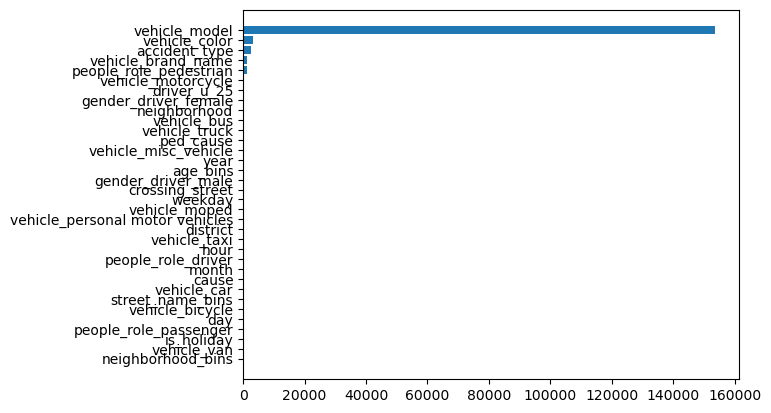

In [28]:
categorical_chosen=[]
def select_features_cat(X, y,score_func=f_classif):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k='all')
    # learn relationship from training data
    fs.fit(X, y)
    # transform train input data
    X_fs = fs.transform(X)
    return X_fs, fs
 
# feature selection
X_fs, fs = select_features_cat(X_cat_enc, y,chi2)
# what are scores for the features
sorted_columns=sorted([x for x in zip(cat_columns,fs.scores_)], key=lambda x: x[1],reverse=True)
chi2_sel=[col[0] for col in sorted_columns[:5]]
categorical_chosen.extend(chi2_sel)
# for i in range(len(sorted_columns)):
#     print(f'Feature {sorted_columns[i][0]}:{sorted_columns[i][1]}')
# plot the scores
cols=[a for a,b in sorted_columns]
scores=[b for a,b in sorted_columns]
plt.barh(cols[::-1], scores[::-1])
plt.show()

<a id='cat_corr'></a>

2. **Categorical Features**.
    - FILTER: Cramers V, Theils U Correlations.
   
[back top](#start)

In [29]:
cramers, theils = [],[]
for col in cat_columns:
    correlation_c=fb3.cramers_corrected_stat(accidents[col],accidents.target)
    correlation_u=fb3.theils_u(accidents[col],accidents.target)
    #print(col, 'cramers', correlation_c)
    cramers.append((col,correlation_c))
    #print(col,'theils', correlation_u)
    theils.append((col,correlation_u))
cram_sel=[col[0] for col in sorted(cramers,key=lambda x:x[1],reverse=True)[0:3]]
categorical_chosen.extend(cram_sel)
print('Selected by Cramers V: ', '\n',cram_sel)
thei_sel=[col[0] for col in sorted(theils,key=lambda x:x[1],reverse=True)[:3]]
categorical_chosen.extend(thei_sel)
print('Selected by Theils U: ', '\n',thei_sel)

Selected by Cramers V:  
 ['accident_type', 'vehicle_brand_name', 'people_role_pedestrian']
Selected by Theils U:  
 ['people_role_pedestrian', 'vehicle_model', 'vehicle_brand_name']


<a id='mut_info'></a>

2. **Categorical Features**.
    - FILTER: Mutual Information/Information Gain.
   
[back top](#start)

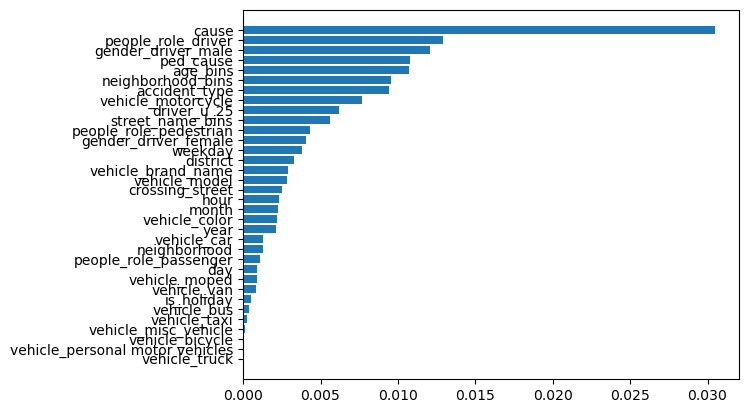

In [30]:
# feature selection
X_fs, fs = select_features_cat(X_cat_enc, y,mutual_info_classif)
# what are scores for the features
sorted_columns=sorted([x for x in zip(cat_columns,fs.scores_)], key=lambda x: x[1],reverse=True)
mut_sel=[col[0] for col in sorted_columns[:5]]
categorical_chosen.extend(mut_sel)
# for i in range(len(sorted_columns)):
#     print(f'Feature {sorted_columns[i][0]}:{sorted_columns[i][1]}')
# plot the scores
cols=[a for a,b in sorted_columns]
scores=[b for a,b in sorted_columns]
plt.barh(cols[::-1], scores[::-1])
plt.show()

<a id='cat_rfe'></a>

2. **Categorical Features**.
    - WRAPPER: Recursive Feature Elimination.
   
[back top](#start)

In [36]:
lr=LogisticRegression(max_iter=3000)
# min_max_scaler = MinMaxScaler()
# X_cat_minmax = min_max_scaler.fit_transform(X_cat_enc)
#X_test_minmax=min_max_scaler.transform(X_test_num)
for n_cols in range(1,X_cat_enc.shape[1]):

    rfe=RFE(lr,n_features_to_select=n_cols)
    rfe.fit(X_cat_enc,y)
    #print([num_columns[x[0]] for x in enumerate(rfe.ranking_) if x[1]==1])\
    if n_cols%10==0:
        print(n_cols)
rfe=RFE(lr,n_features_to_select=3)
rfe.fit(X_cat_enc,y)
rfe_sel=[cat_columns[x[0]] for x in enumerate(rfe.ranking_) if x[1]==1]
categorical_chosen.extend(rfe_sel)
print('Three Selected by RFE: ','\n', rfe_sel)

KeyboardInterrupt: 

<a id='cat_rf'></a>

2. **Categorical Features**.
    - EMBEDDED: Random Forest Classifier.
   
[back top](#start)

In [50]:
rf=RandomForestClassifier(n_estimators=100, random_state=2024)
rf.fit(X_cat_enc,y)
rf_sel=sorted([x[0] for x in zip(cat_columns,rf.feature_importances_)],key=lambda x:x[1],reverse=True)[:3]
categorical_chosen.extend(rf_sel)
print('Three Selected by RandomForest: ','\n', rf_sel)

Three Selected by RandomForest:  
 ['street_name_bins', 'driver_u_25', 'crossing_street']


<a id='cat_lasso'></a>

2. **Numerical Features**.
    - EMBEDDED: Lasso.
   
[back top](#start)

In [51]:
# Lasso
for c in np.linspace(0.001,0.00001,4):
    #print(c)
    lr=LogisticRegression(C=c,penalty='l1',solver='liblinear').fit(X_cat_enc,y)
    selector = SelectFromModel(estimator=lr,prefit=True)
    num_features=len([x[0] for x in zip(cat_columns,selector.get_support()) if x[1]])
    print(num_features)
    # if num_features == 6:
    #     print(num_features,'\n',[x[0] for x in zip(cat_columns,selector.get_support()) if x[1]])
    if num_features <=3:
        print('YEAH')
        print(num_features,'\n',[x[0] for x in zip(cat_columns,selector.get_support()) if x[1]])
        lasso_sel=[x[0] for x in zip(cat_columns,selector.get_support()) if x[1]]
        break
categorical_chosen.extend(lasso_sel)
print('Three Selected by Lasso: ','\n', lasso_sel)

10
10
7
3
YEAH
3 
 ['neighborhood', 'day', 'hour']
Three Selected by Lasso:  
 ['neighborhood', 'day', 'hour']


In [52]:
##Numerical selected
categorical_chosen=Counter(categorical_chosen)
model_dict['categorical_chosen']=categorical_chosen
with open('./data/model_charac.pkl', 'wb') as f:
    pickle.dump(model_dict, f, pickle.HIGHEST_PROTOCOL)

In [53]:
categorical_chosen

Counter({'people_role_pedestrian': 4,
         'accident_type': 3,
         'cause': 3,
         'driver_u_25': 2,
         'neighborhood': 2,
         'ped_cause': 2,
         'gender_driver_male': 2,
         'gender_driver_female': 1,
         'people_role_driver': 1,
         'neighborhood_bins': 1,
         'street_name_bins': 1,
         'crossing_street': 1,
         'day': 1,
         'hour': 1})

# Contingency tables ans Stacked column charts!!!!!!!!!

In [ ]:
###SELECTING CATEGORICAL ONES
accidents['people_role_pass']=[x if x<6 else 10 for x in accidents.people_role_pass]
accidents['vehicles_bus']=[x if x<7 else 10 for x in accidents.vehicles_bus]
accidents['vehicles_car']=[x if x<7 else 10 for x in accidents.vehicles_car]
accidents['vehicles_misc_vehicle']=[x if x<6 else 10 for x in accidents.vehicles_car]
accidents['vehicles_motorcycle']=[x if x<4 else 7 for x in accidents.vehicles_motorcycle]
accidents['vehicles_van']=[x if x<3 else 6 for x in accidents.vehicles_van]
accidents['gender_driver_female']=[x if x<3 else 3 for x in accidents.gender_driver_female]

X=accidents[cat_columns].copy()
#X['people_role_pass']=[x if x<6 else 10 for x in X.people_role_pass]
# X['vehicles_bus']=[x if x<7 else 10 for x in X.vehicles_bus]
# X['vehicles_car']=[x if x<7 else 10 for x in X.vehicles_car]
# X['vehicles_misc_vehicle']=[x if x<6 else 10 for x in X.vehicles_car]
# X['vehicles_motorcycle']=[x if x<4 else 7 for x in X.vehicles_motorcycle]
# X['vehicles_van']=[x if x<3 else 6 for x in X.vehicles_van]
# X['gender_driver_female']=[x if x<3 else 3 for x in X.gender_driver_female]
# y=accidents.target

def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1,stratify=y)
# prepare inputs
X_train,X_test=prepare_inputs(X_train,X_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
sorted_columns=sorted([x for x in zip(cat_columns,fs.scores_)], key=lambda x: x[1],reverse=True)
# for i in range(len(sorted_columns)):
#     print(f'Feature {sorted_columns[i][0]}:{sorted_columns[i][1]}')
# plot the scores
cols=[a for a,b in sorted_columns]
scores=[b for a,b in sorted_columns]
plt.figure(figsize=(10,10))
plt.barh(cols[::-1], scores[::-1])
plt.show()

In [ ]:
with open('../data/model_charac.pkl', 'rb') as f:
    data_pickled=pickle.load(f)
data_pickled.keys()

In [ ]:
##Numerical selected

model_dict['categorical_features']=cols[:5]
model_dict['categorical_features']
with open('../data/model_charac.pkl', 'wb') as f:
    pickle.dump(model_dict, f, pickle.HIGHEST_PROTOCOL)
model_dict.keys()

# Analyzing num_vehicles

In [ ]:
accidents['num_vehicles_aggr']=[x if x <7 else 'the rest' for x in accidents.num_vehicles]
df_num_vehicles=pd.crosstab(accidents.target,accidents.num_vehicles_aggr, normalize='columns')
df_num_vehicles.style.map(lambda x: 'background-color : red' if x<baseline_up and x>baseline_down else 'background-color :green')
idents['num_vehicles_aggr']=[x if x <7 else 'the rest' for x in accidents.num_vehicles]
df_num_vehicles=pd.crosstab(accidents.target,accidents.num_vehicles_aggr, normalize='columns')
df_num_vehicles.style.map(lambda x: 'background-color : green' if x>baseline_up or x<baseline_down else '')

In [ ]:
# Analyzing only 1 and 2 vehicles

new_accidents=accidents[accidents.num_vehicles.isin([1,2])]
colors={}
for j in range(new_accidents.num_vehicles_aggr.nunique()):
    rand_colors = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
    colors[j]=rand_colors

props = {}
for x in [0, 1]:
    for y, col in colors.items():
        props[(x, y)] ={'color': col}
        
mosaic(new_accidents, ['target', 'num_vehicles_aggr'],
       labelizer=lambda k: '',
       properties=props);
# props={}
# props[(0,'Yes')]={'facecolor':'red', 'edgecolor':'white'}
# props[(0,'No')]={'facecolor':'red', 'edgecolor':'white'}
# props[(1,'Yes')]={'facecolor':'xkcd:aqua','edgecolor':'white'}
# props[(1,'No')]=        {'facecolor':'xkcd:aqua','edgecolor':'white'}
# labelizer=lambda k:{(0,'Yes'):357,(1,'Yes'):31,(0,'No'):130,(1,'No'):80}[k]
# mosaic(accidents,['target','num_vehicles_aggr'],labelizer=labelizer,properties=props)
pd.crosstab(accidents.target,accidents.num_vehicles_aggr,normalize='columns').iloc[1].plot(kind='bar');

# Age driver

In [ ]:
accidents[accidents.age_driver==-1].shape

import seaborn as sns
sns.boxplot(x='target',y='age_driver',data=accidents);

age=accidents.age_driver
age_1=accidents[accidents['target'] == 1].age_driver
age_0=accidents[accidents['target'] == 0].age_driver
age_0.mean(), age_1.mean(),age.mean(),age_0.std(), age_1.std(),age.std()

plt.hist(accidents[accidents.age_driver>0][accidents.target==0].age_driver,);

accidents[(accidents['target'] == 0) & (accidents.age_driver>0)].age_driver

plt.hist(accidents[(accidents['target'] == 0) & (accidents.age_driver>0)].age_driver);

plt.hist(accidents[(accidents['target'] == 1) & (accidents.age_driver>0)].age_driver);

plt.hist(accidents[accidents['target'] == 0].age_driver, label='Not', color='green', alpha=0.3, bins='scott')
plt.hist(accidents[accidents['target'] == 1].age_driver, label='Severe', color='red', alpha=0.5, bins=14)
plt.legend()
plt.title('Histogram of Age target')
plt.xlabel("Driver's Age");
sns.histplot(data=accidents, x="age_driver", hue="target", multiple='layer', element='step', binwidth=2, palette=['red', 'green']);

# Perform Two-Sided T-Test comparing mean values of Loan and Non-loan classes
print('Probability value of age_driver coming from same distribution:',
      round(ttest_ind(accidents[(accidents['target'] == 0) & (accidents.age_driver>0)].age_driver,\
                                accidents[(accidents['target'] == 1) & (accidents.age_driver>0)].age_driver).pvalue, 4))




# Define a function for quickly plotting categorical features
def cat_pairplot(plt_data=accidents[num_columns], y_feat='target'):
    # Create a list of all feature names
    feat_cols = list(plt_data.columns)
    
    # Make each plot on a pairplot-like graph with subplots, 2 wide
    num_rows = int(len(feat_cols)/2)
    f, axs = plt.subplots(nrows=num_rows, ncols=2,
                          figsize=(14, 7*num_rows),
                          sharey='row')
    # Add additional vertical space between subplots
    plt.subplots_adjust(hspace=0.5)
    
    # Iterate and illustrate a histogram for each categorical feature, colored with response
    for i in range(len(feat_cols)):
        sns.histplot(ax=axs[int(i/2), i%2], data=plt_data, x=feat_cols[i], hue=y_feat, multiple="dodge", shrink=0.8)
        axs[int(i/2), i%2].set_title(f'Histogram of \'{feat_cols[i]}\' Status against Voter Response');
        # Rotat x-ticks for better readability
        axs[int(i/2), i%2].tick_params(labelrotation=20, pad=1)
        
cat_pairplot();

In [ ]:
baseline_up=accidents.target.value_counts(normalize=True).values[0]
baseline_down=accidents.target.value_counts(normalize=True).values[1]
baseline_up,baseline_down

In [ ]:
cramers, theils = [],[]
for col in cat_columns:
    correlation_c=fb3.cramers_corrected_stat(accidents[col],accidents.target)
    correlation_u=fb3.theils_u(accidents[col],accidents.target)
    #print(col, 'cramers', correlation_c)
    cramers.append((col,correlation_c))
    #print(col,'theils', correlation_u)
    theils.append((col,correlation_u))
sorted(cramers,key=lambda x:x[1],reverse=True)[0:3], sorted(theils,key=lambda x:x[1],reverse=True)[:3]

In [ ]:
sorted(theils,key=lambda x:x[1],reverse=True)

In [ ]:
corre_cat_col=cols[:5]
###Permutations: order matters
###Combinartions: Order does not matter
from itertools import permutations
for perm in [x for x in permutations(corre_cat_col,2)]:
    correlation_c=fb3.cramers_corrected_stat(accidents[perm[0]],accidents[perm[1]])
    correlation_u=fb3.theils_u(accidents[perm[0]],accidents[perm[1]])
    if correlation_c >0.8:
        print(perm, 'cramers', correlation_c)
    if correlation_u >0.8:
        print(perm,'theils', correlation_u)

In [ ]:
X=accidents[cat_columns].copy()
y=accidents.target
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
prepare_inputs(X_train,X_test)

In [ ]:
cat_columns

In [ ]:

feature_dict=fb2.feature_dict
scale_pipe = make_pipeline(StandardScaler())
log_pipe = make_pipeline(PowerTransformer())
categorical_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))
to_scale=[fea for fea in selected_features if fea in feature_dict['numerical_features']]
to_ohe=[fea for fea in selected_features if fea in feature_dict['ordinal_categorical_features']+feature_dict['cardinal_categorical_features']]

transformer = ColumnTransformer(
    transformers=[
        ("scale", scale_pipe, to_scale),
        #("log_transform", log_pipe, to_log),
        ("oh_encode", categorical_pipe, to_ohe),
    ]
)

In [ ]:
fb2.models_list

In [ ]:
scores_df=pd.DataFrame()
kf = RepeatedStratifiedKFold(n_splits=5, random_state=random_state, )

for model in fb2.models_list:
    pipe = Pipeline_imb([('resample', fb2.over.SMOTE(random_state=random_state)), 
                 ('clf', model[1])])
    final_pipe=Pipeline([('transformer', transformer),('pipe',pipe)])
    scores=fb2.cross_validate(final_pipe, X_train, y_train, scoring=fb2.metrics, cv=kf)
    for key in scores:
        scores_df.loc[model[0],key]=scores[key].mean() 
    print(model[0])
scores_df

In [ ]:
##trying different models
# X_train_std,X_test_std=fb2.preprocessing_fetures(train,test,numerical_features,categorical_features,scaler=True)
# print(X_train_std.shape,X_test_std.shape)
scores_df=pd.DataFrame()
kf = RepeatedStratifiedKFold(n_splits=5, random_state=random_state, )
for model in fb2.models_list:
    pipe = Pipeline_imb([("prep", transformer),('resample', fb2.over.SMOTE(random_state=random_state)), 
                 ('clf', model[1])])
    scores=fb2.cross_validate(pipe, X_train.values, y_train.values, scoring=fb2.metrics, cv=kf)
    for key in scores:
        scores_df.loc[model[0],key]=scores[key].mean() 
    print(model[0])
scores_df

In [ ]:
##using only randomforest with oversampling
X_train_std,X_test_std=fb2.preprocessing_fetures(train,test,numerical_features,categorical_features,scaler=True)
scores_over=pd.DataFrame()
kf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
for sampling in fb2.oversamplings.keys():
    print(sampling)
#fb2.models_list[1][1]
    pipe = Pipeline([('resample', fb2.oversamplings[sampling]),
                      
                     ('clf', fb2.models_list[1][1])])
    scores=fb2.cross_validate(pipe, X_train_std, y_train, scoring=fb2.metrics, cv=kf)
    for key in scores:
        scores_over.loc[sampling,key]=scores[key].mean()

In [ ]:
scores_over

In [ ]:
data_pickled['results_uver_rf_pipeline']

In [ ]:
##using only randomforest with undersampling
scores_under=pd.DataFrame()
kf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
for sampling in fb2.undersamplings.keys():
    print(sampling)
#fb2.models_list[1][1]
    pipe = Pipeline([('resample', fb2.undersamplings[sampling]), 
                     ('clf', fb2.models_list[1][1])])
    scores=fb2.cross_validate(pipe, X_train_std, y_train, scoring=fb2.metrics, cv=kf)
    for key in scores:
        scores_under.loc[sampling,key]=scores[key].mean()

In [ ]:
##using only randomforest with over under

scores_combo=pd.DataFrame()
kf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
for sampling in fb2.over_undersamplings.keys():
    print(sampling)
#fb2.models_list[1][1]
    pipe = Pipeline([('resample', fb2.over_undersamplings[sampling]),
                     ('standarization', StandardScaler()), 
                     ('clf', fb2.models_list[1][1])])
    scores=fb2.cross_validate(pipe, X_train, y_train, scoring=fb2.metrics, cv=kf)
    for key in scores:
        scores_combo.loc[sampling,key]=scores[key].mean()

In [ ]:

validate_scores={}
kf = KFold(n_splits=5, random_state=42, shuffle=True)
pipe = Pipeline([('resample', fb2.over.SMOTE(random_state=random_state)),
                 ('standarization', StandardScaler()), 
                 ('clf', RandomForestClassifier(n_estimators=100, random_state=13))])
#imba_pipeline = make_pipeline(SMOTE(random_state=42), RandomForestClassifier(n_estimators=100, random_state=13))
scores=cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv=kf)
scores.mean()

In [ ]:
##using only randomforest with undersampling and oversampling
from imblearn.pipeline import Pipeline, make_pipeline
scores_under_over=pd.DataFrame()
kf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
# for sampling in fb2.oversamplings.keys():
#     print(sampling)
# #fb2.models_list[1][1]
pipe = Pipeline([('undersample', fb2.undersamplings['OSS']),
                ('oversample', fb2.oversamplings['ROS']),
                 ('standarization', StandardScaler()), 
                 ('clf', fb2.models_list[1][1])])
scores=fb2.cross_validate(pipe, X_train, y_train, scoring=fb2.metrics, cv=kf)
for key in scores_under_over:
    scores_under_over.loc[0,key]=scores[key].mean()

In [ ]:
###Selection so far
#features
numerical_features=['num_vehicles','hood_count',]
categorical_features=['district','pedestrian','shift','weekend',]
##model
models_list.append(('rf',RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=10, max_features=3, random_state=random_state))
 ##pipeline   
RandomOverSampler, SMoteTomek,OneSidedSelection,StandardScaler

In [ ]:
pred1=[pred[1] for pred in predictions]


In [ ]:
RandomForestClassifier().get_params()

In [ ]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
}
new_params = {'clf__' + key: params[key] for key in params}
kf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
pipe = Pipeline([('undersample', fb2.undersamplings['OSS']),
                ('oversample', fb2.oversamplings['ROS']),
                 ('standarization', StandardScaler()), 
                 ('clf', RandomForestClassifier(class_weight='balanced',random_state=fb2.random_state))])
grid_imba = GridSearchCV(pipe, param_grid=new_params, cv=kf, scoring='roc_auc',
                        return_train_score=True)
grid_imba.fit(X_train, y_train);

In [ ]:
grid_imba.best_params_, grid_imba.best_score_

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
pipe = Pipeline([('undersample', fb2.undersamplings['OSS']),
                ('oversample', fb2.oversamplings['ROS']),
                 ('standarization', StandardScaler()), 
                 ('clf', RandomForestClassifier(class_weight='balanced',
                                                random_state=fb2.random_state,max_depth=12,
                                               n_estimators=100))])
scores=fb2.cross_validate(pipe, X_train, y_train, scoring=fb2.metrics, cv=kf)
for key in scores:
    print(key,scores[key].mean())

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline
pipe.fit(X_train,y_train)
predictions=pipe.predict(X_test)

In [ ]:
import sklearn.metrics as m
m.recall_score(y_test,predictions),m.precision_score(y_test,predictions),m.accuracy_score(y_test,predictions),m.roc_auc_score(y_test,predictions)

In [ ]:
###class weight
X_train=fb2.X_train
y_train=fb2.y_train
X_test=fb2.X_test
y_test=fb2.y_test
# numerical_features=fb2.numerical_features
# categorical_features=fb2.categorical_features
numerical_features=['num_vehicles','hood_count',]
categorical_features=['district','pedestrian','shift','weekend',]


X_train,X_test=fb2.preprocessing_fetures(X_train,X_test,numerical_features,categorical_features)
# fb2.undersampling(X_train,y_train)
# X_train.shape, y_train.shape
models_list=fb2.models_list
models=fb2.models
random_state=fb2.random_state

accuracies=[]
recalls=[]
precisions=[]
aucs=[]
for model in models_list:
    scores = fb2.scoring_model(X_train,X_test,y_train,y_test,model[1])
    recalls.append(scores[0])
    precisions.append(scores[1])
    accuracies.append(scores[2])
    aucs.append(scores[3])
results=pd.DataFrame()
results['recall']=recalls
results['precision']=precisions
results['accuracy']=accuracies
results['auc']=aucs
results.index=[model[0] for model in models_list]
results

In [ ]:
accuracies=[]
recalls=[]
precisions=[]
aucs=[]
undersamplings=fb2.undersamplings

for key in undersamplings.keys():
    print(key)
    start=time.time()
    X_under, y_under= undersampling_dataset(X_train,y_train,model=undersamplings[key])
    end=time.time()
    print(key,round((end-start)/60,2),'minutes')
    scores=fb2.scoring_model(X_under,X_test,y_under,y_test,models_dict['forest']['name'])
    recalls.append(scores[0])
    precisions.append(scores[1])
    accuracies.append(scores[2])
    aucs.append(scores[3])
results_under=pd.DataFrame()
results_under['recall']=recalls
results_under['precision']=precisions
results_under['accuracy']=accuracies
results_under['auc']=aucs
results_under.index=list(undersamplings.keys())
results_under

In [ ]:
with open('output_pickle.pkl', 'rb') as f:
    data_pickled=pickle.load(f)
data_pickled['results_under_w/rf']

In [ ]:
start=time.time()
end=tiime.time()
start

In [ ]:
end=tiime.time()
end

In [ ]:
import pickle

# Package the variables we want to export
data = {
    'results_under_w/rf': results_under,  # Record what was vectorized
    'results_w/models': results,
    'results_over': results_over,
    
              # For encoding additional test data
    
    'X_train': X_train,        # Train
    'y_train': y_train,
    
    
    }


# 'wb' - Write + Binary File
with open('output_pickle.pkl', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def compress(string):
    index = 0
    compressed = ""
    len_str = len(string)
    while index != len_str:
        count = 1
        while (index < len_str-1) and (string[index] == string[index+1]):
            count = count + 1
            index = index + 1
        if count == 1:
            compressed += str(string[index])
        else:
            compressed += str(string[index]) + str(count)
        index = index + 1
    return compressed


string= "djjjjjjjjppjjjjjjjjjjjrhejrejj"

print(compress(string))

if len(compress(string)) > len(string):
    print(string)

In [ ]:
data_pickled['results_uver_under_rf_pipeline']=scores_under_over

In [ ]:
data_pickled.keys()

In [ ]:
# with open('output_pickle.pkl', 'rb') as f:
#     data_pickled=pickle.load(f)
# data_pickled['results_over_under']=results_over_under
with open('output_pickle.pkl', 'wb') as f:
    pickle.dump(data_pickled, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
accuracies=[]
recalls=[]
precisions=[]
aucs=[]
oversamplings=fb2.oversamplings
oversampling_dataset=fb2.oversampling_dataset

for key in oversamplings.keys():
    print(key)
    start=time.time()
    X_under, y_under= oversampling_dataset(X_train,y_train,model=oversamplings[key])
    end=time.time()
    print(key,round((end-start)/60,2),'minutes')
    scores=fb2.scoring_model(X_under,X_test,y_under,y_test,models_dict['forest']['name'])
    recalls.append(scores[0])
    precisions.append(scores[1])
    accuracies.append(scores[2])
    aucs.append(scores[3])
results_over=pd.DataFrame()
results_over['recall']=recalls
results_over['precision']=precisions
results_over['accuracy']=accuracies
results_over['auc']=aucs
results_over.index=list(oversamplings.keys())
results_over

In [ ]:
data_pickled['results_over_w/rf'][data_pickled['results_over_w/rf']['auc']>0.58]

In [ ]:
accuracies=[]
recalls=[]
precisions=[]
aucs=[]
over_undersamplings=fb2.over_undersamplings
#over_undersampling_dataset=fb2.over_undersampling_dataset

for key in over_undersamplings.keys():
    print(key)
    start=time.time()
    X_under, y_under= oversampling_dataset(X_train,y_train,model=over_undersamplings[key])
    end=time.time()
    print(key,round((end-start)/60,2),'minutes')
    scores=fb2.scoring_model(X_under,X_test,y_under,y_test,models_dict['forest']['name'])
    recalls.append(scores[0])
    precisions.append(scores[1])
    accuracies.append(scores[2])
    aucs.append(scores[3])
results_over_under=pd.DataFrame()
results_over_under['recall']=recalls
results_over_under['precision']=precisions
results_over_under['accuracy']=accuracies
results_over_under['auc']=aucs
results_over_under.index=list(over_undersamplings.keys())
results_over_under

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
 

# over = ...
# under = ...
# define pipeline
#pipeline = Pipeline(steps=[('o', over), ('u', under)])
#oversamplings['SVMSMOTE']
undersamplings=fb2.undersamplings
#undersamplings['NCL']
###########################
model = models_dict['forest']['name']
# define resampling
over = oversamplings['SVMSMOTE']
under = undersamplings['NCL']
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

In [ ]:
scores.mean()

In [ ]:
from sklearn.model_selection import cross_val_predict
pred=pipeline.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,pred),'\n')
print("Recall :", recall_score(y_test,pred))
print("auc: ", roc_auc_score(y_test,pred))

In [ ]:
# Create the training and test data
numerical_features=['num_vehicles','hood_count',]
categorical_features=['district','pedestrian','shift','weekend',]

accidents['hour']=accidents.hour.astype(str)
accidents['year']=accidents.year.astype(str)
acc_20=accidents[accidents.year=='2020']
acc_19=accidents[accidents.year=='2019']
test=accidents[accidents.year.isin(['2019','2020'])]
train=accidents[~accidents.year.isin(['2019','2020'])]

X_train=pd.concat([train[numerical_features],pd.get_dummies(train[categorical_features],drop_first=True)],axis=1)
y_train=train.target
X_test=pd.concat([test[numerical_features],pd.get_dummies(test[categorical_features],drop_first=True)],axis=1)
y_test=test.target
ratio_strategy=0.8
smote = SMOTE(sampling_strategy=ratio_strategy,random_state = 99)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
# Instantiate the visualizer with the classification model
model = GradientBoostingClassifier(random_state=44)
# visualizer = ROCAUC(model, classes=["no_injuries", "injuries"])

# visualizer.fit(X_train_over, y_train_over)        # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)        # Evaluate the model on the test data
# visualizer.show()                       # Finalize and show the figure
model.fit(X_train_over,y_train_over)

print('f2_score: ',fbeta_score(y_test,model.predict(X_test),beta=2))
recall= recall_score(y_test,model.predict(X_test))
print('Recall: ', recall)

infile = open('../scores/scores.pkl','rb')
scores_dict = pickle.load(infile)
infile.close()
# scores_dict={}
# scores_dict['scores']={}
# scores_dict['features']=[]
# scores_dict['params']={}
best_recall=scores_dict['recall']['score']
#best_recall=0
best_auc=scores_dict['auc']['score']
#best_auc=0
accuracy=accuracy_score(y_test,model.predict(X_test))
print('Accuracy: ', accuracy)
print('Cohen-Kappa :', cohen_kappa_score(y_test,model.predict(X_test)))
auc=roc_auc_score(y_test,model.predict(X_test))
print('AUC :', auc)
if recall > best_recall:
    
    scores_dict['recall']['score']=recall
    scores_dict['recall'].update( {'features' : numerical_features+categorical_features} )
   
    scores_dict['recall']['params']['smote']=ratio_strategy
    scores_dict['recall']['params']['model']=model
    scores_dict['recall']['params']['accuracy']=accuracy
    best_recall=recall
    outfile = open('../scores/scores.pkl','wb')
    pickle.dump(scores_dict,outfile)
    outfile.close()    
    print('Recall improved: ', round(recall,4))
    

if auc > best_auc:
  
    scores_dict['auc']['score']=auc
    scores_dict['auc'].update( {'features' : numerical_features+categorical_features} )
   
    scores_dict['auc']['params']['smote']=ratio_strategy
    scores_dict['auc']['params']['model']=model
    scores_dict['auc']['params']['accuracy']=accuracy
    best_auc=auc
    outfile = open('../scores/scores.pkl','wb')
    pickle.dump(scores_dict,outfile)
    outfile.close()

    print('auc improved: ', round(auc,2))
        

In [ ]:
def choosing_ratio_strategy(ratio_strategy):    
    numerical_features=['num_vehicles','hood_count',]
    categorical_features=['district','pedestrian','shift','weekend',]

    accidents['hour']=accidents.hour.astype(str)
    accidents['year']=accidents.year.astype(str)
    acc_20=accidents[accidents.year=='2020']
    acc_19=accidents[accidents.year=='2019']
    test=accidents[accidents.year.isin(['2019','2020'])]
    train=accidents[~accidents.year.isin(['2019','2020'])]

    X_train=pd.concat([train[numerical_features],pd.get_dummies(train[categorical_features],drop_first=True)],axis=1)
    y_train=train.target
    X_test=pd.concat([test[numerical_features],pd.get_dummies(test[categorical_features],drop_first=True)],axis=1)
    y_test=test.target
    print('Ratio: ', ratio_strategy)
    smote = SMOTE(sampling_strategy=ratio_strategy,random_state = 99)
    X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
    # Instantiate the visualizer with the classification model
    ss=StandardScaler()
    X_train=ss.fit_transform(X_train_over)
    X_test=ss.transform(X_test)
    model = GradientBoostingClassifier(random_state=44)
    
    model.fit(X_train, y_train_over) 
    #preds=[1 if x[1] >0.45 else 0 for x in model.predict_proba(X_test)]
    predictions=model.predict(X_test)
    recall= recall_score(y_test,predictions)
    print('Recall: ', recall)

    accuracy=accuracy_score(y_test,predictions)
    print('Accuracy: ', accuracy)
    auc=roc_auc_score(y_test,predictions)
    print('AUC :', auc)
for x in np.linspace(0.5,.9,5):
    choosing_ratio_strategy(x)

In [ ]:
[0 if value='TurboTax' else 1 for value in df.column_name]

In [ ]:
cf=confusion_matrix(y_test,visualizer.predict(X_test))
proba_1=[x[1] for x in model.predict_proba(X_test)]
def threshold_clac(threshold, proba_1, y_test):
    preds=[1 if x>threshold else 0 for x in proba_1]
    return recall_score(y_test,preds), roc_auc_score(y_test,preds), accuracy_score(y_test,preds)
for t in np.linspace(0.1,.5,5):
    print(t,threshold_clac(t,proba_1,y_test))

In [ ]:
print(threshold_clac(0.45,proba_1,y_test))
probas=[x[1] for x in visualizer.predict_proba(X_test)]
preds=[1 if x>.45 else 0 for x in probas]
cf=confusion_matrix(y_test,model.predict(X_test))
pd.DataFrame(cf, columns=['pred_0','pred_1'],index=['actual_0','actual_1'])

In [ ]:
def choosing_model(model,scoring='recall'):    
    numerical_features=['num_vehicles','hood_count',]
    categorical_features=['district','pedestrian','shift','weekend',]

    accidents['hour']=accidents.hour.astype(str)
    accidents['year']=accidents.year.astype(str)
    acc_20=accidents[accidents.year=='2020']
    acc_19=accidents[accidents.year=='2019']
    test=accidents[accidents.year.isin(['2019','2020'])]
    train=accidents[~accidents.year.isin(['2019','2020'])]

    X_train=pd.concat([train[numerical_features],pd.get_dummies(train[categorical_features],drop_first=True)],axis=1)
    y_train=train.target
    X_test=pd.concat([test[numerical_features],pd.get_dummies(test[categorical_features],drop_first=True)],axis=1)
    y_test=test.target
    ratio_strategy=0.7
    smote = SMOTE(sampling_strategy=ratio_strategy,random_state = 99)
    X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
    ss=StandardScaler()
    X_train=ss.fit_transform(X_train_over)
    X_test=ss.transform(X_test)
    # Instantiate the visualizer with the classification model
    #model = GradientBoostingClassifier(random_state=44)
    print(model)
    scoring=scoring
    kfold=KFold(n_splits=5, random_state=random_state,shuffle=True)

    return cross_val_score(model,X_train,y_train,cv=kfold,scoring=scoring)
    

random_state=3456
models_list=[]
models_list.append(('logreg',LogisticRegression(C= 1, random_state=random_state)))
models_list.append(('rf',RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=10, max_features=3, random_state=random_state)))
models_list.append(('lda', LinearDiscriminantAnalysis()))
models_list.append(('linearsvc',LinearSVC(C=1.0, random_state=random_state, class_weight='balanced')))
models_list.append(('gbc', GradientBoostingClassifier(random_state=random_state)))
models_list.append(('XGBoost',XGBClassifier(random_state=random_state)))
results=[]
names=[]
for name,model in models_list:
    print(name)
    results.append(choosing_model(model))
    names.append(name)
    #print(type(key))
    

In [ ]:
accuracies=[]
for name in names:
    accuracies.append(resultats[name]['accuracy'])

fig=plt.figure()
fig.suptitle('Accuracy')
ax=fig.add_subplot(111)
plt.boxplot(accuracies)
ax.set_xticklabels(names)

recalls=[]
for name in names:
    recalls.append(resultats[name]['recall'])

fig=plt.figure()
fig.suptitle('Recall')
ax=fig.add_subplot(111)
plt.boxplot(recalls)
ax.set_xticklabels(names)

In [ ]:
numerical_features=['num_vehicles','hood_count',]
categorical_features=['district','pedestrian','shift','weekend',]

accidents['hour']=accidents.hour.astype(str)
accidents['year']=accidents.year.astype(str)
acc_20=accidents[accidents.year=='2020']
acc_19=accidents[accidents.year=='2019']
test=accidents[accidents.year.isin(['2019','2020'])]
train=accidents[~accidents.year.isin(['2019','2020'])]

X_train=pd.concat([train[numerical_features],pd.get_dummies(train[categorical_features],drop_first=True)],axis=1)
y_train=train.target
X_test=pd.concat([test[numerical_features],pd.get_dummies(test[categorical_features],drop_first=True)],axis=1)
y_test=test.target
ratio_strategy=0.7
smote = SMOTE(sampling_strategy=ratio_strategy,random_state = 99)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
ss=StandardScaler()
x_train=ss.fit_transform(X_train_over)
X_test=ss.transform(X_test)
# Instantiate the visualizer with the classification model
model = RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=10, max_features=3, random_state=random_state)
#print(model)
visualizer = ROCAUC(model, classes=["no_injuries", "injuries"])
visualizer.fit(X_train, y_train)
#preds=[1 if x[1] >0.45 else 0 for x in visualizer.predict_proba(X_test)]

recall= recall_score(y_test,visualizer.predict(X_test))
print('Recall: ', recall)

accuracy=accuracy_score(y_test,preds)
print('Accuracy: ', accuracy)
auc=roc_auc_score(y_test,preds)
print('AUC :', auc)

In [ ]:
cf=confusion_matrix(y_test,visualizer.predict(X_test))
proba_1=[x[1] for x in visualizer.predict_proba(X_test)]
def threshold_clac(threshold, proba_1, y_test):
    preds=[1 if x>threshold else 0 for x in proba_1]
    return recall_score(y_test,preds), roc_auc_score(y_test,preds), accuracy_score(y_test,preds)
for t in np.linspace(0.1,.5,5):
    print(t,threshold_clac(t,proba_1,y_test))

In [ ]:
preds=visualizer.predict(X_test)
tp=0
tn=0
fp=0
fn=0
conf_matrix=pd.Series(['tp' if (x[0]==x[1]) and (x[0]==1) else 'tn' if x[0]==x[1] else 'fn' if x[0]==1 and x[1]==0 else 'fp' for x in zip(y_test,preds)])


In [ ]:
false_negatives=X_test.iloc[conf_matrix[conf_matrix=='fn'].index]
(false_negatives[[x for x in false_negatives.columns if 'district' in x]].sum()).sort_values(ascending=False)

In [ ]:
false_negatives.groupby('district')['neighborhood'].count()

In [ ]:
X=accidents.drop('target',axis=1).copy()
numerical_f=accidents.select_dtypes(exclude='object').columns
categorical_f=accidents.select_dtypes(include='object').columns
X=pd.concat([accidents[numerical_f],pd.get_dummies(accidents[categorical_f],drop_first=True)],axis=1)
y=accidents.target


In [ ]:
model=ExtraTreesClassifier(n_estimators=100)
model.fit(X,y)
model.feature_importances_

In [ ]:
fimp=model.feature_importances_
len(fimp), X.shape
x=dict(zip(X.columns, fimp))
sorted(x.items(), key=lambda item: item[1],reverse=True)

In [ ]:
###FUNCTIONS


def sorting_by_corr(dataframe, features, target):
    
    """Sorting all features by its correlation with target"""
    
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    nova_data = pd.DataFrame()
    
    for item in data[features].select_dtypes(exclude=['int', 'float']).columns:
            
        prova = pd.get_dummies(data[item])
        nova_data = pd.concat([nova_data,prova], axis=1)
        
    for item in data[features].select_dtypes(include=['int', 'float']).columns:
        nova_data[item] = data[item]
    nova_data[target] = dataframe[target]    
     
    correlation = nova_data.corr()
    
    
    correlation[target] = [x if x >= 0 else (-1) * x for x in correlation[target]]
            
    
    all_features = list(correlation[target].sort_values(ascending=False)[1::].index)
    final_df = nova_data[all_features]
    return all_features, final_df


def changing_threshold(proba, threshold_majority):
    
    """recalculating predictions based on threshold"""
    
    return [0 if x[0] >= threshold_majority else 1 for x in proba]

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return TP, FP, TN, FN


def selecting_features(dataframe, target, features):
    
    """Function to select features through combinationa"""
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes, 'object')
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)


    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    
    
    clf = LogisticRegression()        
    clf.fit(X_train_std, y_resampled)
    score = clf.score(X_test_std, y_test)
    pred = clf.predict(X_test_std)
    prob = clf.predict_proba(X_test_std)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    fbeta = fbeta_score(y_test, pred, beta=0.5)
    
    return accuracy, recall, precision, f1, fbeta, prob, y_test


def selecting_features_corr(dataframe, target, features):
    
    """It is a similar function thatn the one with combinations. In this case, features
    are already separated and dummied"""
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)


    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    
    
    clf = LogisticRegression()        
    clf.fit(X_train_std, y_resampled)
    score = clf.score(X_test_std, y_test)
    pred = clf.predict(X_test_std)
    prob = clf.predict_proba(X_test_std)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    fbeta = fbeta_score(y_test, pred, beta=0.5)
    
    return accuracy, recall, precision, f1, fbeta, prob, pred

### Pickling resultat

def pickling_resultat(resultat):
    
    for i in resultat.keys():
        with open('resultat{}.pkl'.format(i), 'wb') as picklefile:
            pickle.dump(resultat[i], picklefile)
            
def depickling_resultat(amount_features):
    resultat = {}
    for i in range (1, amount_features + 1):
        
        with open('resultat{}.pkl'.format(i), 'rb') as f:
            resultat[i] = pickle.load(f)
    return resultat

def selecting_model(dataframe, target, features, model):
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes, 'object')
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)

    #print('Labels counts in y:', np.bincount(y), (np.bincount(y)[1]/np.bincount(y)[0]))
    #print('Labels counts in y_train:', np.bincount(y_train), (np.bincount(y_train)[1]/np.bincount(y_train)[0]))
    #print('Labels counts in y_test:', np.bincount(y_test), (np.bincount(y_test)[1]/np.bincount(y_test)[0]))

    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    

                
    model.fit(X_train_std, y_resampled)
    pred = model.predict(X_test_std)
    #prob = clf.predict_proba(X_test_std)
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
        
    return accuracy, recall, precision, f1, pred, y_test
    
    
def preprocessing_features(df, features):
    
    "Getting ready the features for the model"
    
    data = df[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes)
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    features_array = np.array(data)
    
    return features_array    


def selecting_model_oversampling(train,test, features, model):
    
    train.majority = train[train.victims_alert == 0]
    train.minority = train[train.victims_alert == 1]

    train_minority_upsampled = resample(train_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(train_majority),    # to match majority class
                                     random_state=1) # reproducible results

    train_upsampled = pd.concat([train_majority, train_minority_upsampled])

    y = train_upsampled.victims_alert
    X = preprocessing_features(train_upsampled, features)
    y_test = test.victims_alert
    X_test = preprocessing_features(test, features)
    ss = StandardScaler()
    ss.fit(X)
    X_train_std = ss.transform(X)
    X_test_std = ss.transform(X_test)       
    clf = model.fit(X_train_std, y)
    pred = clf.predict(X_test_std)
    
    return pred, y_test
    
    
def selecting_model_downsampling(train,test, features, model):
    
    train.majority = train[train.victims_alert == 0]
    train.minority = train[train.victims_alert == 1]

    train_majority_downsampled = resample(train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(train_minority),     # to match minority class
                                 random_state=1) # reproducible results

    train_downsampled = pd.concat([train_minority, train_majority_downsampled])
    
    y = train_downsampled.victims_alert
    X = preprocessing_features(train_downsampled, features)
    y_test = test.victims_alert
    X_test = preprocessing_features(test, features)
    ss = StandardScaler()
    ss.fit(X)
    X_train_std = ss.transform(X)
    X_test_std = ss.transform(X_test)       
    clf = model.fit(X_train_std, y)
    pred = clf.predict(X_test_std)
    
    return pred, y_test
    

In [ ]:
####Values to keep all the time
metrics = ['recall', 'precision', 'f1_score', 'roc_auc', 'accuracy']
random_state = 1
baseline = 1 - df['victims_alert'].sum()/df.shape[0]

features = []
pickle_files = ['accuracy_features.pkl', 'f1_features.pkl',\
                'precision_features.pkl', 'recall_features.pkl']

dict_features = {}
count = 0
for item in pickle_files:
    
    with open(item, 'rb') as f:
        list_features = pickle.load(f)
        count = count + len(list_features)
        dict_features[item[0:-4]] = count
        dict_features[item[0:-4] + "_list"] = list_features

    for i in list_features:
        features.append(i)
dict_features.keys(), metrics

In [ ]:
models_dict = {'log_reg': {'name': LogisticRegression(C= 100, random_state=random_state)},
'forest':{'name': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10, max_features=1, random_state=random_state)}, 
'gbc': {'name': GradientBoostingClassifier(random_state=random_state, learning_rate=0.01)},
       'linearsvc':{'name': LinearSVC(C=1.0, random_state=random_state, class_weight='balanced')},\
              'Perceptron': {'name': Perceptron(class_weight='balanced', random_state=random_state)},
              'MLPClassifier': {'name': MLPClassifier(random_state=random_state)}}
for i in models_dict.keys():
    print(models_dict[i]['name'])

In [ ]:
###Try with different models
metrics = ['recall', 'precision', 'f1_score', 'roc_auc', 'accuracy']
for key in models_dict.keys():
    models_dict[key].update({key: None for key in metrics}) 


for key in models_dict.keys():
    
    accuracies = []
    recalls =[]
    precisions = []
    f1s = []
    roc_aucs = []
    count = 0
    for i in features:
        
        count = count + 1
        a, r, p, f, pred, y_test = selecting_model(df,target, i, models_dict[key]['name'])
        
        accuracies.append(a)
        recalls.append(r)
        precisions.append(p)
        f1s.append(f)

        fpr, tpr, _ = roc_curve(y_test, pred)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        if count%10 == 0:
            print(count)
        
    models_dict[key]['accuracy'] = accuracies
    models_dict[key]['recall'] = recalls
    models_dict[key]['precision'] = precisions
    models_dict[key]['f1_score'] = f1s
    models_dict[key]['roc_auc'] = roc_aucs
    print(key)
with open('dictionary_models.pkl', 'wb') as picklefile:
    pickle.dump(models_dict, picklefile)
print("DONE")

In [ ]:
with open('dictionary_models.pkl', 'rb') as f:
    models_dict = pickle.load(f)

In [ ]:
def plotting_models_and_metrics(n_rows, n_columns, name_metric):

    fig, ax = plt.subplots(n_rows,n_columns, figsize=(10,10))
    x_axis = [x for x in range(1, len(models_dict[key][name_metric]) + 1)]
    models = [y for y in models_dict.keys()]
    count = 0

    for i in range(3):
        for j in range(2):

            ax[i, j].plot(x_axis, models_dict[models[count]][name_metric])
            ax[i, j].legend([models[count]])
            count = count + 1
    fig.suptitle(name_metric.title(), fontsize=15); # or plt.suptitle('Main title')

In [ ]:
for name_metric in metrics:
    n_rows = 3
    n_columns = 2
    #name_metric = 'accuracy'

    plotting_models_and_metrics(n_rows, n_columns, name_metric)

In [ ]:
for key in models_dict.keys():
    
    x_axis = [x for x in range(1, len(models_dict[key]['recall']) + 1)]
    plt.plot(x_axis,models_dict[key]['recall']);
    plt.title('Recall')
plt.legend(models_dict.keys());

In [ ]:
for key in models_dict.keys():
    
    x_axis = [x for x in range(1, len(models_dict[key]['precision']) + 1)]
    plt.plot(x_axis,models_dict[key]['precision']);
    plt.title('Precision')
plt.legend(models_dict.keys());

In [ ]:
for key in models_dict.keys():
    
    x_axis = [x for x in range(1, len(models_dict[key]['f1_score']) + 1)]
    plt.plot(x_axis,models_dict[key]['f1_score']);
    plt.title('F1 Score')
plt.legend(models_dict.keys());

In [ ]:
for key in models_dict.keys():
    
    x_axis = [x for x in range(1, len(models_dict[key]['roc_auc']) + 1)]
    plt.plot(x_axis,models_dict[key]['roc_auc']);
    plt.title('Roc auc')
plt.legend(models_dict.keys());

In [ ]:
#Let's see the high per metric
maxims = {}

for item in metrics:
    maxims[item] = [0, '']
    
    
for key in models_dict.keys():
    
    print('Accuracy: ', key,max(models_dict[key]['accuracy']))
    print("Recall: ", key, max(models_dict[key]['recall']))
    for metric in metrics:
        
        if max(models_dict[key][metric]) >= maxims[metric][0]:
            maxims[metric][0] = round(max(models_dict[key][metric]),6)
            maxims[metric][1] = key
    
maxims

In [ ]:

models_dict[maxims['roc_auc'][1]]['roc_auc'] = [round(x,6) for x in models_dict[maxims['roc_auc'][1]]['roc_auc']]
fea_index = models_dict[maxims['roc_auc'][1]]['roc_auc'].index(maxims['roc_auc'][0])

a, r, p, f1, pred, y_test = selecting_model(df, target, features[fea_index], models_dict[maxims['roc_auc'][1]]['name'])
r

In [ ]:
###Analyzing best Roc_auc

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fn

from sklearn.metrics import auc, precision_recall_curve, average_precision_score
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area ={})'.format(round(roc_auc, 4)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print("Flase Negatives: ", fn)
print("Amount of ones predicted: ", pred.sum()/len(y_test))

In [ ]:
### Run it the first time only
msk = np.random.rand(len(df)) < 0.75

In [ ]:
####Oversampling minority

with open('mask.pkl', 'rb') as f:
    msk = pickle.load(f)

#msk = np.random.rand(len(df)) < 0.75
train = df[msk]
test = df[~msk]
    

train_majority = train[train.victims_alert==0]

train_minority = train[train.victims_alert==1]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(train_majority),    # to match majority class
                                 random_state=1) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
 
# Display new class counts
train_upsampled.victims_alert.value_counts()

"""y = train_upsampled.victims_alert
X = preprocessing_features(train_upsampled, features[10])
y_test = test.victims_alert
X_test = preprocessing_features(test, features[10]) """
models_dict_oversampling = {key: None for key in models_dict.keys()}


for key in models_dict_oversampling.keys():
    models_dict_oversampling[key] = {key: None for key in metrics}



for key in models_dict.keys():
    
    print(key)
    accuracies = []
    recalls = []
    precisions = []
    f1s = []
    roc_aucs = []
    count = 0
    
    for i in features:
        
        count = count + 1
        y = train_upsampled.victims_alert
        X = preprocessing_features(train_upsampled, i)
        y_test = test.victims_alert
        X_test = preprocessing_features(test, i)
        ss = StandardScaler()
        ss.fit(X)
        X_train_std = ss.transform(X)
        X_test_std = ss.transform(X_test)          
        clf = models_dict[key]['name'].fit(X_train_std, y)
        pred = clf.predict(X_test_std)
        accuracy = accuracy_score(y_test, pred)
        recall = recall_score(y_test,pred)
        f1 = f1_score(y_test, pred)
        precision = precision_score(y_test,pred)
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        fpr, tpr, _ = roc_curve(y_test, pred)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        if count%10 == 0:
            print(count)
        
    models_dict_oversampling[key]['accuracy'] = accuracies
    models_dict_oversampling[key]['recall'] = recalls
    models_dict_oversampling[key]['precision'] = precisions
    models_dict_oversampling[key]['f1_score'] = f1s
    models_dict_oversampling[key]['roc_auc'] = roc_aucs
with open('mask.pkl', 'wb') as f:
    pickle.dump(msk, f)
with open('oversampling_models.pkl', 'wb') as picklefile:
    pickle.dump(models_dict_oversampling, picklefile)

In [ ]:
with open('oversampling_models.pkl', 'rb') as picklefile:
    models_dict_oversampling = pickle.load(picklefile)
models_dict_oversampling

In [ ]:
maxims_oversampling = {}
for item in metrics:
    maxims_oversampling[item] = [0, '']
    
    
for key in models_dict_oversampling.keys():
    
    print('Accuracy: ', key,max(models_dict_oversampling[key]['accuracy']))
    print("Recall: ", key, max(models_dict_oversampling[key]['recall']))
    for metric in metrics:
        
        if metric != 'recall':
        
            if max(models_dict_oversampling[key][metric]) >= maxims_oversampling[metric][0]:
                maxims_oversampling[metric][0] = round(max(models_dict_oversampling[key][metric]),6)
                maxims_oversampling[metric][1] = key
        else:
            if (max(models_dict_oversampling[key][metric]) >= maxims_oversampling[metric][0]) and (max(models_dict_oversampling[key][metric]) < 1):
                maxims_oversampling[metric][0] = round(max(models_dict_oversampling[key][metric]),6)
                maxims_oversampling[metric][1] = key
maxims_oversampling

In [ ]:
####Analyzingthe best roc_auc

models_dict_oversampling[maxims_oversampling['roc_auc'][1]]['roc_auc'] = [round(x,6) for x in models_dict_oversampling[maxims_oversampling['roc_auc'][1]]['roc_auc']]
fea_index = models_dict_oversampling[maxims_oversampling['roc_auc'][1]]['roc_auc'].index(maxims_oversampling['roc_auc'][0])

pred, y_test = selecting_model_oversampling(train, test, features[fea_index], models_dict[maxims_oversampling['roc_auc'][1]]['name'])

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print("Recall: ", recall_score(y_test, pred),  "ROC-AUC: ", roc_auc)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()


fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area ={})'.format(round(roc_auc, 4)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print("Flase Negatives: ", fn)
print("Amount of ones predicted: ", pred.sum()/len(y_test))
print("Features: ", features[fea_index])

In [ ]:
####Analyzingthe best recall
to_consider = 'recall'
models_dict_oversampling[maxims_oversampling[to_consider][1]][to_consider] = [round(x,6) for x in models_dict_oversampling[maxims_oversampling[to_consider][1]][to_consider]]
fea_index = models_dict_oversampling[maxims_oversampling[to_consider][1]][to_consider].index(maxims_oversampling[to_consider][0])

pred, y_test = selecting_model_oversampling(train, test, features[fea_index], models_dict[maxims_oversampling[to_consider][1]]['name'])

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print("Recall: ", recall_score(y_test, pred),  "ROC-AUC: ", roc_auc)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()


fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area ={})'.format(round(roc_auc, 4)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print("Flase Negatives: ", fn)
print("Amount of ones predicted: ", pred.sum()/len(y_test))
print("Features: ", features[fea_index])

In [ ]:
###Downsampling

train_majority_downsampled = resample(train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(train_minority),     # to match minority class
                                 random_state=1) # reproducible results
 
# Combine majority class with upsampled minority class
train_downsampled = pd.concat([train_majority_downsampled, train_minority])
 
# Display new class counts

models_dict_downsampling = {key: None for key in models_dict.keys()}


for key in models_dict_downsampling.keys():
    models_dict_downsampling[key] = {key: None for key in metrics}



for key in models_dict.keys():
    
    print(key)
    accuracies = []
    recalls =[]
    precisions = []
    f1s = []
    roc_aucs = []
    count = 0
    
    for i in features:
        
        count = count + 1
        y = train_downsampled.victims_alert
        X = preprocessing_features(train_downsampled, i)
        y_test = test.victims_alert
        X_test = preprocessing_features(test, i)
        ss = StandardScaler()
        ss.fit(X)
        X_train_std = ss.transform(X)
        X_test_std = ss.transform(X_test)          
        clf = models_dict[key]['name'].fit(X_train_std, y)
        pred = clf.predict(X_test_std)
        accuracy = accuracy_score(y_test, pred)
        recall = recall_score(y_test,pred)
        f1 = f1_score(y_test, pred)
        precision = precision_score(y_test,pred)
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        fpr, tpr, _ = roc_curve(y_test, pred)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        if count%10 == 0:
            print(count)
        
        
    models_dict_downsampling[key]['accuracy'] = accuracies
    models_dict_downsampling[key]['recall'] = recalls
    models_dict_downsampling[key]['precision'] = precisions
    models_dict_downsampling[key]['f1_score'] = f1s
    models_dict_downsampling[key]['roc_auc'] = roc_aucs
    
with open('downsampling_models.pkl', 'wb') as picklefile:
    pickle.dump(models_dict_downsampling, picklefile)

In [ ]:
with open('downsampling_models.pkl', 'rb') as picklefile:
    models_dict_downsampling = pickle.load(picklefile)

In [ ]:
maxims_downsampling = {}

for item in metrics:
    maxims_downsampling[item] = [0, '']
    
    
for key in models_dict_downsampling.keys():
    
    print('Accuracy: ', key,max(models_dict_downsampling[key]['accuracy']))
    print("Recall: ", key, max(models_dict_downsampling[key]['recall']))
    for metric in metrics:
        
        if max(models_dict_downsampling[key][metric]) >= maxims_downsampling[metric][0]:
            maxims_downsampling[metric][0] = round(max(models_dict_downsampling[key][metric]),6)
            maxims_downsampling[metric][1] = key
    
maxims_downsampling

In [ ]:
####Analyzingthe best roc_auc
to_consider = 'roc_auc'
models_dict_downsampling[maxims_downsampling[to_consider][1]][to_consider] = [round(x,6) for x in models_dict_downsampling[maxims_downsampling[to_consider][1]][to_consider]]
fea_index = models_dict_downsampling[maxims_downsampling[to_consider][1]][to_consider].index(maxims_downsampling[to_consider][0])

pred, y_test = selecting_model_downsampling(train, test, features[fea_index], models_dict[maxims_downsampling[to_consider][1]]['name'])

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print("Recall: ", recall_score(y_test, pred),  "ROC-AUC: ", roc_auc)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()


fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area ={})'.format(round(roc_auc, 4)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print("Flase Negatives: ", fn)
print("Amount of ones predicted: ", pred.sum()/len(y_test))
print("Features: ", features[fea_index])

In [ ]:
####Analyzingthe best recall
to_consider = 'recall'

models_dict_downsampling[maxims_downsampling[to_consider][1]][to_consider] = [round(x,6) for x in models_dict_downsampling[maxims_downsampling[to_consider][1]][to_consider]]
fea_index = models_dict_downsampling[maxims_downsampling[to_consider][1]][to_consider].index(maxims_downsampling[to_consider][0])

pred, y_test = selecting_model_downsampling(train, test, features[fea_index], models_dict[maxims_downsampling[to_consider][1]]['name'])

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print("Recall: ", recall_score(y_test, pred),  "ROC-AUC: ", roc_auc)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()


fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area ={})'.format(round(roc_auc, 4)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print("Flase Negatives: ", fn)
print("Amount of ones predicted: ", pred.sum()/len(y_test))
print("Features: ", features[fea_index])

In [ ]:
from sklearn.utils.fixes import signature
average_precision = average_precision_score(y_test, pred)
precision, recall, _ = precision_recall_curve(y_test, pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));


# Cost Sensitive Analysis
## Next steps: add smote to costcla
### try Bayes method
### try QuadraticDiscriminantAnalysis and Fuzzy SVM
### Introduce cross validationa as mentioned in a youtube video
### class_weight is your friend

In [ ]:
obj = pd.DataFrame(pd.Series(df.victims_alert).value_counts())
obj['Percentage'] = obj['victims_alert']/obj['victims_alert'].sum()
obj.index = ['Negative (No deaths nor severely injured)', 'Positive (Deaths and/or severely injured)']
obj.rename(columns = {'victims_alert':'Frequency'}, inplace=True)
obj

In [ ]:
prova_features = preprocessing_features(df, features[40])

In [ ]:
def preparing_X_and_y(dataframe, features, target):
    
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)
            
    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)


    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    
    return X_train_std, X_test_std, y_resampled, y_test

X_train, X_test, y_train, y_test = preparing_X_and_y(df, features[37], target)



In [ ]:
cost_mat[:, 0] = false_positive_cost
cost_mat[:, 1] = false_negative_cost
cost_mat[:, 2] = true_positive_cost
cost_mat[:, 3] = true_negative_cost

In [ ]:
### FP, FN, TP, TN
costs = [1,20, -1, 0]
cost_mat = np.zeros((df.shape[0], 4))
cost_mat_train = np.zeros((X_train.shape[0], 4))
cost_mat_test = np.zeros((X_test.shape[0], 4))
for i in range(0,4):
    cost_mat[:, i] = costs[i] ##FP
    cost_mat_train[:, i] = costs[i]    
    cost_mat_test[:, i] = costs[i]     
###Cost all zeros
cost_all_zeros = cost_loss(y_test, np.zeros(len(y_test)), cost_mat_test)
###
cost_all_ones = cost_loss(y_test, np.ones(len(y_test)), cost_mat_test)
cost_to_beat = min(cost_all_ones, cost_all_zeros)
print("all zeros: ", cost_all_zeros)
print("all ones: ", cost_all_ones)

In [ ]:
models_dict_cs = {'log_reg': {'F': LogisticRegression(C= 100, random_state=random_state)},
'forest':{'F': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10, max_features=1, random_state=random_state)}, 
'gbc': {'F': GradientBoostingClassifier(random_state=random_state, learning_rate=0.01)},
       'linearsvc':{'F': LinearSVC(C=1.0, random_state=random_state, class_weight='balanced')},\
              'Perceptron': {'F': Perceptron(class_weight='balanced', random_state=random_state)},
              'MLPClassifier': {'F': MLPClassifier(random_state=random_state)}}
measures = {"f1_score": f1_score, "precision": precision_score, 
            "recall": recall_score, "accuracy": accuracy_score, 'roc_auc': roc_auc_score,\
           'savings': savings_score}

# Adding savings as a metric

In [ ]:
resultats = pd.DataFrame(columns=measures.keys())

for key in models_dict_cs.keys():
    
    print(key)
    accuracies = []
    recalls =[]
    precisions = []
    f1s = []
    roc_aucs = []
    savings = []
    
    
    for i in features:

        X_train, X_test, y_train, y_test = preparing_X_and_y(df, i, target)
    
        clf = models_dict_cs[key]['F'].fit(X_train, y_train)
    
        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        recall = recall_score(y_test,pred)
        f1 = f1_score(y_test, pred)
        precision = precision_score(y_test,pred)
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        fpr, tpr, _ = roc_curve(y_test, pred)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        ###define clas_mat_test
        
        cost_mat_test = np.zeros((X_test.shape[0], 4))
        for i in range(0,4):
            cost_mat_test[:, i] = costs[i]   
        saving = savings_score(y_test, pred, cost_mat_test)
        savings.append(saving)
    
        
    models_dict_cs[key]['accuracy'] = accuracies
    models_dict_cs[key]['recall'] = recalls
    models_dict_cs[key]['precision'] = precisions
    models_dict_cs[key]['f1_score'] = f1s
    models_dict_cs[key]['roc_auc'] = roc_aucs
    models_dict_cs[key]['savings'] = savings
    
with open('cs_models.pkl', 'wb') as picklefile:
    pickle.dump(models_dict_cs, picklefile)

In [ ]:
with open('cs_models.pkl', 'rb') as picklefile:
    models_dict_cs = pickle.load(picklefile)
    
models_dict_cs.keys()

In [ ]:
maxims_cs = {}

for item in measures:
    maxims_cs[item] = [0, ['']]
    
    
for key in models_dict_cs.keys():
    for subkey in models_dict_cs[key].keys():
        if subkey != 'F':
    
            print(key, subkey, max(models_dict_cs[key][subkey]), sum(models_dict_cs[key][subkey])/len(models_dict_cs[key][subkey]))
    for measure in measures:
        
        if max(models_dict_cs[key][measure]) > maxims_cs[measure][0]:
            maxims_cs[measure][0] = round(max(models_dict_cs[key][measure]),6)
            ##add models here
            maxims_cs[measure][1] = [key]
        elif max(models_dict_cs[key][measure]) == maxims_cs[measure][0]:
            maxims_cs[measure][1].append(key)
            
    
maxims_cs

In [ ]:
###Investigating maxim precision
models_dict_cs['log_reg']['precision']

In [ ]:
to_consider = 'precision'
model = maxims_cs[to_consider][1][0]
print(model)
models_dict_cs[model][to_consider] = [round(x,6) for x in models_dict_cs[model][to_consider]]
fea_index = models_dict_cs[model][to_consider].index(maxims_cs[to_consider][0])



X_train, X_test, y_train, y_test = preparing_X_and_y(df, features[fea_index], target)
    
clf = models_dict_cs[model]['F'].fit(X_train, y_train)
    
pred = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print("Recall: ", recall_score(y_test, pred),  "ROC-AUC: ", roc_auc)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()


fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area ={})'.format(round(roc_auc, 4)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print("Flase Negatives: ", fn)
print("Amount of ones predicted: ", pred.sum()/len(y_test))
print("Features: ", features[fea_index])
print(to_consider, savings_score(y_test,pred, cost_mat_test))

In [ ]:
resultats_cs = pd.DataFrame(columns=measures.keys())


for model in models_dict_cs.keys():
 
    resultats_cs.loc[model] = [sum(models_dict_cs[model][measure])/len(models_dict_cs[model][measure])\
                               for measure in measures.keys()]
    
resultats_cs

In [ ]:
models_dict_bmr = {'log_reg': {'F': LogisticRegression(C= 100, random_state=random_state)},
'forest':{'F': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10, max_features=1, random_state=random_state)}, 
'gbc': {'F': GradientBoostingClassifier(random_state=random_state, learning_rate=0.01)},
       'svc':{'F': SVC(C=1.0, random_state=random_state, class_weight='balanced', probability=True)},
              'MLPClassifier': {'F': MLPClassifier(random_state=random_state)}}

In [ ]:
measures = {"f1_score": f1_score, "precision": precision_score, 
            "recall": recall_score, "accuracy": accuracy_score, 'roc_auc': roc_auc_score,\
           "savings": savings_score}

In [ ]:
def calculating_metrics(mydict,features):

    for key in mydict.keys():

        print(key)
        accuracies = []
        recalls =[]
        precisions = []
        f1s = []
        roc_aucs = []
        savings = []


        for i in features:

            X_train, X_test, y_train, y_test = preparing_X_and_y(df, i, target)

            clf = mydict[key]['F'].fit(X_train, y_train)

            pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, pred)
            recall = recall_score(y_test,pred)
            f1 = f1_score(y_test, pred)
            precision = precision_score(y_test,pred)
            accuracies.append(accuracy)
            recalls.append(recall)
            precisions.append(precision)
            f1s.append(f1)
            fpr, tpr, _ = roc_curve(y_test, pred)
            roc_auc = roc_auc_score(y_test,pred)
            roc_aucs.append(roc_auc)
            ###define clas_mat_test

            cost_mat_test = np.zeros((X_test.shape[0], 4))
            for i in range(0,4):
                cost_mat_test[:, i] = costs[i]   
            saving = savings_score(y_test, pred, cost_mat_test)
            savings.append(saving)


        mydict[key]['accuracy'] = accuracies
        mydict[key]['recall'] = recalls
        mydict[key]['precision'] = precisions
        mydict[key]['f1_score'] = f1s
        mydict[key]['roc_auc'] = roc_aucs
        mydict[key]['savings'] = savings

    with open(mydict + 'mydict.pkl', 'wb') as picklefile:
        pickle.dump(mydict, picklefile)

In [ ]:
bmr_features = dict_features['recall_features_list']

In [ ]:
models_dict_bmr = calculating_metrics(models_dict_bmr, bmr_features)

In [ ]:
with open('models_dict_bmr.pkl', 'wb') as picklefile:
    pickle.dump(models_dict_bmr, picklefile )

In [ ]:
def creating_dict_maxims(mydict,measures):

    maxims = {}

    for item in measures:
        maxims[item] = [0, ['']]
    
    
    for key in mydict.keys():
    
        print('Accuracy: ', key,max(mydict[key]['accuracy']))
        print("Recall: ", key, max(mydict[key]['recall']))
        print("Roc_auc: ", key, max(mydict[key]['roc_auc']))
        for measure in measures:
        
            if max(mydict[key][measure]) > maxims[measure][0]:
                maxims[measure][0] = round(max(mydict[key][measure]),6)
                
                maxims[measure][1] = [key]
            elif max(mydict[key][measure]) == maxims[measure][0]:
                maxims[measure][1].append(key)
                
    return maxims
            
    
maxims_bmr = creating_dict_maxims(models_dict_bmr, measures)

# Adding Bayes Minimum Risk

In [ ]:
X_train, X_test, y_train, y_test = preparing_X_and_y(df, features[41], target)

for model in models_dict_bmr.keys():
    print(model)
    # Fit
    models_dict_bmr[model]["F"].fit(X_train, y_train)
    # Predict
    models_dict_bmr[model]["c"] = models_dict_bmr[model]["F"].predict(X_test)
    models_dict_bmr[model]["p"] = models_dict_bmr[model]["F"].predict_proba(X_test)
    #models_dict_bmr[model]["p_train"] = models_dict_bmr[model]["F"].predict_proba(X_train)
models_dict_bmr.keys()

with open('models_dict_bmr.pkl', 'wb') as picklefile:
    pickle.dump(models_dict_bmr, picklefile)

In [ ]:
with open('models_dict_bmr.pkl', 'rb') as picklefile:
    models_dict_bmr = pickle.load(picklefile)

In [ ]:
def obtaining_resultats(mydict, measures):
    
    
    resultats = pd.DataFrame(columns=measures.keys())
    
    for model in mydict.keys():
 
        resultats.loc[model] = [measures[measure](y_test, mydict[model]["c"]) if measure != 'savings' else measures[measure](y_test, models_dict_bmr[model]["c"], cost_mat_test)\
 for measure in measures.keys()]
    
    return resultats

resultats_bmr = obtaining_resultats(models_dict_bmr, measures)

resultats_bmr

In [ ]:
del models_dict_bmr['CSDT']
models_dict_bmr.keys()

In [ ]:


for model in list(models_dict_bmr):
    models_dict_bmr[model+"-BMR"] = {"F": BayesMinimumRiskClassifier()}
    # Fit
    models_dict_bmr[model+"-BMR"]["F"].fit(y_test, models_dict_bmr[model]["p"])  
    # Calibration must be made in a validation set
    # Predict
    models_dict_bmr[model+"-BMR"]["c"] = models_dict_bmr[model+"-BMR"]["F"].predict(models_dict_bmr[model]["p"], cost_mat_test)
    # Evaluate
    resultats_bmr.loc[model+"-BMR"] = 0
    resultats_bmr.loc[model+"-BMR", measures.keys()] = \
    [measures[measure](y_test, models_dict_bmr[model+"-BMR"]["c"]) if measure != 'savings' else measures[measure](y_test, models_dict_bmr[model]["c"], cost_mat_test)\
 for measure in measures.keys()]    
resultats_bmr


# Adding costcla

In [ ]:
from costcla.models import CostSensitiveDecisionTreeClassifier, CostSensitiveLogisticRegression, CostSensitiveRandomForestClassifier
 
    
models_dict_bmr["CSDT"] = {"F": CostSensitiveDecisionTreeClassifier(criterion_weight='balanced')}
models_dict_bmr['CS-LR'] = {"F": CostSensitiveLogisticRegression(random_state=random_state)}
models_dict_bmr['CSRC'] = {"F": CostSensitiveRandomForestClassifier(combination="weighted_voting")}
for i in ['CSDT', "CS-LR", 'CSRC']:
    # Fit
    models_dict_bmr[i]["F"].fit(X_train, y_train, cost_mat_train)
    # Predict
    models_dict_bmr[i]["c"] = models_dict_bmr[key]["F"].predict(X_test)
    # Evaluate
    resultats_bmr.loc[i] = 0
    resultats_bmr.loc[i, measures.keys()] = \
    [measures[measure](y_test, models_dict_bmr[i]["c"]) if measure != 'savings' else measures[measure](y_test, models_dict_bmr[i]["c"], cost_mat_test)\
     for measure in measures.keys()]  
    #[measures[measure](y_test, classifiers["CSRP"]["c"]) for measure in measures.keys()]    
print(resultats_bmr)

# ThresholdingOptimization

# One soluntion via Bayes following guy in internet and one singular set of features

# Finalize it with Fuzzy SVM

In [ ]:
resultats["sav"] = np.zeros(resultats.shape[0])
for model in models_dict_cs.keys():
    resultats["sav"].loc[model] = (savings_score(y_test, models_dict_cs[model]["class"], cost_mat_test))
resultats


In [ ]:
classifiers = {"RF": {"f": RandomForestClassifier(random_state=random_state)},
               "DT": {"f": DecisionTreeClassifier(random_state=random_state)},
               "LR": {"f": LogisticRegression(random_state=random_state)}}

for model in classifiers.keys():
    # Fit
    classifiers[model]["f"].fit(X_train, y_train)
    # Predict
    classifiers[model]["c"] = classifiers[model]["f"].predict(X_test)
    classifiers[model]["p"] = classifiers[model]["f"].predict_proba(X_test)
    classifiers[model]["p_train"] = classifiers[model]["f"].predict_proba(X_train)
classifiers.keys()

In [ ]:
measures = {"f1": f1_score, "pre": precision_score, 
            "rec": recall_score, "acc": accuracy_score, 'roc_auc': roc_auc_score}
results = pd.DataFrame(columns=measures.keys())

# Evaluate each model in classifiers
for model in classifiers.keys():
 
    results.loc[model] = [measures[measure](y_test, classifiers[model]["c"]) for measure in measures.keys()]
    
results

In [ ]:
from costcla.metrics import savings_score, cost_loss 

# Evaluate the savings for each model
results["sav"] = np.zeros(results.shape[0])
for model in classifiers.keys():
    results["sav"].loc[model] = (savings_score(y_test, classifiers[model]["c"], cost_mat_test))
results["cost_vs_baseline"] = np.zeros(results.shape[0])
for model in classifiers.keys():
    results["cost_vs_baseline"].loc[model] = (cost_loss(y_test, classifiers[model]["c"], cost_mat_test) - cost_all_zeros)

# TODO: plot results
print(results)

In [ ]:
#Plot the results
colors = sns.color_palette()

figsize = (10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

In [ ]:
from costcla.models import BayesMinimumRiskClassifier
ci_models = models_dict_cs.keys()

for model in list(models_dict_cs):
    classifiers[model+"-BMR"] = {"F": BayesMinimumRiskClassifier()}
    # Fit
    classifiers[model+"-BMR"]["F"].fit(y_test, classifiers[model]["p"])  
    # Calibration must be made in a validation set
    # Predict
    classifiers[model+"-BMR"]["class"] = classifiers[model+"-BMR"]["F"].predict(classifiers[model]["p"], cost_mat_test)
    # Evaluate
    results.loc[model+"-BMR"] = 0
    results.loc[model+"-BMR", measures.keys()] = \
    [measures[measure](y_test, classifiers[model+"-BMR"]["c"]) for measure in measures.keys()]
    results["sav"].loc[model+"-BMR"] = savings_score(y_test, classifiers[model+"-BMR"]["c"], cost_mat_test)
    
print(results)



In [ ]:
# Plot the results
ind = np.arange(results.shape[0])
colors = sns.color_palette()
figsize = (10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

In [ ]:
from costcla.models import CostSensitiveRandomPatchesClassifier

classifiers["CSRP"] = {"f": CostSensitiveRandomPatchesClassifier(combination='weighted_voting')}
# Fit
classifiers["CSRP"]["f"].fit(X_train, y_train, cost_mat_train)
# Predict
classifiers["CSRP"]["c"] = classifiers["CSRP"]["f"].predict(X_test)
# Evaluate
results.loc["CSRP"] = 0
results.loc["CSRP", measures.keys()] = \
[measures[measure](y_test, classifiers["CSRP"]["c"]) for measure in measures.keys()]
results["sav"].loc["CSRP"] = savings_score(y_test, classifiers["CSRP"]["c"], cost_mat_test)
    
print(results)

In [ ]:
# Plot the results
ind = np.arange(results.shape[0])
figsize = (10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis()

In [ ]:
from time import time
from scipy.stats import randint as sp_randint
from operator import itemgetter
from sklearn.grid_search import RandomizedSearchCV

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

clf = RandomForestClassifier()

# specify parameters and distributions to sample from
# from http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
param_dist = {"n_estimators": [10, 20, 50, 100, 1000],
              "max_depth": [3, None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(1, 100),
              "min_samples_leaf": sp_randint(1, 100),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
classifiers["RS-RF"] = {"f": RandomizedSearchCV(clf, param_distributions=param_dist,
                                                n_iter=20, n_jobs=4, verbose=1)}
# Fit
start = time()
classifiers["RS-RF"]["f"].fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds"
      " parameter settings." % ((time() - start),))

report(classifiers["RS-RF"]["f"].grid_scores_)

In [ ]:
# Predict
classifiers["RS-RF"]["c"] = classifiers["RS-RF"]["f"].predict(X_test)
# Evaluate
results.loc["RS-RF"] = 0
results.loc["RS-RF", measures.keys()] = \
[measures[measure](y_test, classifiers["RS-RF"]["c"]) for measure in measures.keys()]
results["sav"].loc["RS-RF"] = savings_score(y_test, classifiers["RS-RF"]["c"], cost_mat_test)
    
print(results)

In [ ]:
rf_acc = []
rf_rec = []
rf_auc = []
rf_fn = []

for item in features:
    
    
    y = train_upsampled.victims_alert
    X = preprocessing_features(train_upsampled, item)
    y_test = test.victims_alert
    X_test = preprocessing_features(test, item) 


    clf = RandomForestClassifier(random_state=random_state).fit(X,y)

    # Predict on training set
    pred = clf.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    _, _, fn, _ = confusion_matrix(y_test, pred).ravel()
    
    rf_fn.append(fn)
    print( 'Random Forest False Negative: ', fn )
    # How's our accuracy?
    
    rf_acc.append(accuracy_score(y_test, pred))
    
    #print( 'Random Forest Accuracy: ', round(accuracy_score(y_test, pred),4) )
    rf_rec.append(recall_score(y_test, pred))

    #print('Random Forest Recall: ',round(recall_score(y_test, pred), 4))
    rf_auc.append(auc(fpr, tpr))
    #print('Random Forest AUC: ',round(auc(fpr, tpr), 4))

In [ ]:
min(rf_fn), rf_fn.index(min(rf_fn))

In [ ]:
max(rf_acc), rf_acc.index(max(rf_acc)), max(rf_rec), rf_rec.index(max(rf_rec)), max(rf_auc), rf_auc.index(max(rf_auc))

In [ ]:
y = train_upsampled.victims_alert
X = preprocessing_features(train_upsampled, features[35])
y_test = test.victims_alert
X_test = preprocessing_features(test, features[35]) 

# Train model

clf = RandomForestClassifier(random_state=random_state).fit(X,y)

# Predict on training set

pred = clf.predict(X_test)

prob = clf.predict_proba(X_test)

 
# Is our model still predicting just one class?
#print( np.unique( pred_y_1 ) )
# [0 1]
 
# How's our accuracy?

print( 'Random Forest Accuracy: ', round(accuracy_score(y_test, pred),4) )

print('Random Forest Recall: ',round(recall_score(y_test, pred), 4))



print( 'Random Forest: ',pred.sum(), len(pred), len(pred) *0.25, pred.sum()/len(pred))


In [ ]:
prob_0 = [x[0] for x in prob]
prob_1 = [x[1] for x in prob]


for item in np.linspace(0.5,1, 5):
    
    pred_0_t = [0 if x >= item else 1 for x in prob_0 ]
    acc_0_t = accuracy_score(y_test, pred_0_t)
    rec_0_t = recall_score(y_test,pred_0_t)
    prec_0_t = precision_score(y_test, pred_0_t)
    _, _, fn_0_t, _ = confusion_matrix(y_test, pred_0_t).ravel()
    print(item, acc_0_t, rec_0_t, fn_0_t, prec_0_t, sum(pred_0_t), len(pred_0_t))

In [ ]:
plt.plot(x_features, rf_rec);
for key in dict_features.keys():
    plt.axvline(x=dict_features[key], c = 'red')
plt.title("Recall(acc, f1, precision, recall)");

In [ ]:
x_features = [x for x in range(1,len(features) + 1)]
plt.plot(x_features, rf_acc);
for key in dict_features.keys():
    plt.axvline(x=dict_features[key], c = 'red')
plt.title("Accuracy(acc, f1, precision, recall)")

In [ ]:

for key in dict_features.keys():
    plt.axvline(x=dict_features[key], c = 'red')
plt.plot(x_features, rf_auc);

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
RNG = 42
# Make some synthetic imbalanced binary classification data
y = train_upsampled.victims_alert
X = preprocessing_features(train_upsampled, features[39])
y_test = test.victims_alert
X_test = preprocessing_features(test, features[39]) 

metric_names = ['f1', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=3)
scv = StratifiedKFold(n_splits=3)
clf = RandomForestClassifier(random_state=random_state)
for metric in metric_names:
    score1 = cross_val_score(clf, X, y, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(clf, X, y, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]

In [ ]:
for r in np.linspace(0.3,0.5, 4):
    for model in models_dict.keys():
    
        print(r, models_dict[model]['name'], selecting_model_smote(df, target, r, features[39], models_dict[model]['name']))

In [ ]:
max_smote_perceptron = (0.2/3 + 0.3)
a, b, _, _, pred, y_test  = selecting_model_smote\
(df,target,max_smote_perceptron,features[39],models_dict['Perceptron']['name'])
a, b

In [ ]:
###Random Forest confusion matrix analysis
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()


from sklearn.metrics import auc, precision_recall_curve, average_precision_score
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area ={})'.format(round(roc_auc, 4)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fn, sum(pred)

In [ ]:
###Trying SVC with penalisation.




def selecting_model_smote(dataframe, target, ratio, features,model):
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes, 'object')
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=ratio, random_state=2018).fit_sample(X_train, y_train)

    #print('Labels counts in y:', np.bincount(y), (np.bincount(y)[1]/np.bincount(y)[0]))
    #print('Labels counts in y_train:', np.bincount(y_train), (np.bincount(y_train)[1]/np.bincount(y_train)[0]))
    #print('Labels counts in y_test:', np.bincount(y_test), (np.bincount(y_test)[1]/np.bincount(y_test)[0]))

    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    

                
    model.fit(X_train_std, y_resampled)
    pred = model.predict(X_test_std)
    #prob = clf.predict_proba(X_test_std)
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
        
    return accuracy, recall, precision, f1, pred, y_test

In [ ]:
###chapter 2

class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [ ]:


def selecting_model(dataframe, target, features, **models_dict):
    
    data = dataframe[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            #print(item, data[item].dtypes, 'object')
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    X = np.array(data)
    y = dataframe[target]
    y = (np.where (y > 0, 1, 0))
    y = np.reshape(y, len(y))
    
    

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)
    
    
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)

    #print('Labels counts in y:', np.bincount(y), (np.bincount(y)[1]/np.bincount(y)[0]))
    #print('Labels counts in y_train:', np.bincount(y_train), (np.bincount(y_train)[1]/np.bincount(y_train)[0]))
    #print('Labels counts in y_test:', np.bincount(y_test), (np.bincount(y_test)[1]/np.bincount(y_test)[0]))

    ss = StandardScaler()
    ss.fit(X_resampled)
    X_train_std = ss.transform(X_resampled)
    X_test_std = ss.transform(X_test)
    
    
    for item in models_dict.keys():

        
  
        clf = models_dict[item]['name']
            
        clf.fit(X_train_std, y_resampled)
        score = clf.score(X_test, y_test)
        pred = clf.predict(X_test_std)
        #prob = clf.predict_proba(X_test_std)
        accuracy = accuracy_score(y_test, pred)
        recall = recall_score(y_test, pred)
        #models_dict[item]['pred'].append(pred)
        #models_dict[item]['proba'].append(prob)
        #models_dict[item]['accuracy'].append(accuracy)
        #models_dict[item]['recall'].append(recall)
        #models_dict[key]['count'].append(num)
        print(str(models_dict[item]))
        print('Misclassified samples: %d' % (y_test != pred).sum())
        print('Amount of victims predicted: ', pred.sum())
        print("How many predictions over real: ", pred.sum()/y_test.sum())
        print("Predicted one vs total compared with original: ", pred.sum()/len(y_test), y_test.sum()/len(y_test))
        print('Victims_alert missed: ',  sum([1 for x,y in zip(y_test,pred) if x ==1 and y==0]))

        print('Accuracy: %.4f' % accuracy_score(y_test, pred))
        print('Recall: {}'.format(recall_score(y_test, pred)))
        print('Precision: {}'.format(precision_score(y_test, pred)))
        print('f1_score: {}'.format(f1_score(y_test, pred)))
        print('fbeta_score: {}'.format(fbeta_score(y_test, pred, beta=0.5)))
    
    
    


In [ ]:
selecting_model(df, target,features_max_f1_score[1], **models_dict)

In [ ]:
from sklearn.svm import SVC
SVC()

In [ ]:
def preprocessing_features(df, features):
    
    "Getting ready the features for the model"
    
    data = df[features].copy()
    data.reset_index(inplace=True)
    for item in features:
        if data[item].dtypes == 'object':
            print(item, data[item].dtypes)
            prova = pd.get_dummies(data[item], drop_first=True)
            data = pd.concat([data,prova], axis=1)
            data.drop(item, axis=1, inplace=True)

    features_array = np.array(data)
    
    return features_array
preprocessing_features(df,)

In [ ]:
a = np.array([1,0,1,0,0,0])
b = np.array([0,0,1,0,0,0])
sum([1 for x,y in zip(a,b) if x ==1 and y==0])

In [ ]:
features_array = preprocessing_features(df, all_features)

In [ ]:
X = features_array
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    
    """loading initial information"""
    
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        """calculate score with all features included initialy in X"""
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        "while the number of initial features is bigger than the value k_features given"

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        
        """Preparing the X based on selected features"""
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        
        """scoreing the model based on gthe selected features selected by indices"""
        
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [ ]:
numeric_fetuares = df[all_features].select_dtypes(exclude='object').columns

In [ ]:
X = np.array(df[numeric_fetuares])
y = df[target].values
knn = KNeighborsClassifier(n_neighbors=5)
# selecting features
sbs = SBS(knn, k_features=1)
#sbs.fit(X_train_std, y_train)
sbs.fit(X, y)

In [ ]:

def _calc_score(X_train, y_train, X_test, y_test):
        pp = Perceptron()
        pp.fit(X_train, y_train)
        y_pred = pp.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        return score, y_pred, y_test
    
dim = X_train.shape[1]
indices_ = tuple(range(dim))
subsets_ = [indices_]
score, pred, real = _calc_score(X_train, y_train, 
                                 X_test, y_test)

In [ ]:
len(all_features)

In [ ]:
len(pred), len(real), pred.sum(), real.sum()
misclassified_samples = []
cagades = []

for x,y in zip(real,pred):
    if x != y:
        misclassified_samples.append(1)
    
print('Misclassified Samples: ', sum(misclassified_samples))

In [ ]:
score

In [ ]:
from sklearn.base import clone

In [ ]:
models = ['Perceptron', 'LogisticRegression', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier',\
          'KNeighborsClassifier']
for itrem in models:    
    calculant_recall(df,target, features, itrem)

In [ ]:
for i in df.columns:
    print(i, len(df[i].unique()))

print('Number of Nan;', df.isnull().sum().sum())

In [ ]:
len(y_pred), y_pred.sum()

In [ ]:
##Calculate recall
evaluation_metrics['recall'], evaluation_metrics['precision']
##THIS ONE SUCKS

In [ ]:
##SECOND TRY-----ADDING FEATURES

In [ ]:
##we will add some features
set_features = ['hour_day', 'month', 'latitude', 'longitude', 'year', 'victims_alert']

df1 = (pd.concat([df[set_features], pd.get_dummies(df['month'])], axis=1, join_axes=[df.index])).drop('month', axis= 1)  

first_set_features = df1.columns
first_set_features.drop('victims_alert')

In [ ]:
def preprocess_features(df1):
    """Prepares input features from accidents.

    Args:
    final_accidents dataframe: A Pandas DataFrame expected to contain data
      from the Barcelona Accidents.
    Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    """
    selected_features = df1[first_set_features]
    processed_features = selected_features.copy()
    return processed_features

def preprocess_targets(df1):
    """Prepares target features (i.e., labels) from BarcelonaAccidents data set.

    Args:
    final_accidents_dataframe: A Pandas DataFrame expected to contain data
      from the BarcelonaAccidents data set.
    Returns:
    A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Create a boolean categorical feature representing whether the
    # median_house_value is above a set threshold.
    output_targets["victims_alert"] = df1["victims_alert"].astype(float)
    return output_targets

msk = np.random.rand(len(df1)) < 0.75
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(df1[msk])
training_targets = preprocess_targets(df1[msk])

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(df1[~msk])
validation_targets = preprocess_targets(df1[~msk])

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

In [ ]:


def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regression model.

    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.

    Args:
    learning_rate: A `float`, the learning rate.
    regularization_strength: A `float` that indicates the strength of the L1
       regularization. A value of `0.0` means no regularization.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.

    Returns:
    A `LinearClassifier` object trained on the training data.
    """

    periods = 12
    steps_per_period = steps / periods

    # Create a linear classifier object.
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
    )

    # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["victims_alert"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["victims_alert"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["victims_alert"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss (on validation data):")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])

        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

        # Compute training and validation loss.
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        # Occasionally print the current loss.
        print("  period {:02d} : {:0.2f}".format(period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")
    
    

    #validation_predictions = np.array([item['probabilities'] for item in validation_probabilities])

    _ = plt.hist(validation_predictions)

    evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

    print("AUC on the validation set: {:0.4f}".format(evaluation_metrics['auc']))
    print("Accuracy on the validation set: {:0.6f}".format(evaluation_metrics['accuracy']))
    print("AUC_precision-recall {:0.5f}".format(evaluation_metrics['auc_precision_recall']))

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

def model_size(estimator):
    variables = estimator.get_variable_names()
    size = 0
    for variable in variables:
        if not any(x in variable 
            for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
            size += np.count_nonzero(estimator.get_variable_value(variable))
    return size

In [ ]:
for item in np.linspace(0,1, 5):
    linear_classifier = train_linear_classifier_model(
        learning_rate=0.000005,
        # TWEAK THE REGULARIZATION VALUE BELOW
        regularization_strength =item,
        steps=500,
        batch_size=100,
        feature_columns =construct_feature_columns(training_examples),
        training_examples=training_examples,
        training_targets=training_targets,
        validation_examples=validation_examples,
        validation_targets=validation_targets)
    print("Model size:", model_size(linear_classifier))

In [ ]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["victims_alert"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['probabilities'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: {:0.4f}".format(evaluation_metrics['auc']))
print("Accuracy on the validation set: {:0.2f}".format(evaluation_metrics['accuracy']))
print("AUC_precision-recall {:0.3f}".format(evaluation_metrics['auc_precision_recall']))

validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

average_precision = average_precision_score(validation_targets, validation_probabilities)
precision, recall, _ = precision_recall_curve(validation_targets, validation_probabilities)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
##Calculate recall
evaluation_metrics['recall'], evaluation_metrics['precision']
##THIS ONE SUCKS but it doesn't?

## THIRD TRY--- ALL FEATURES AND REGLARIZATION

In [ ]:
a = [1,2,3]

In [ ]:
##we will add some features
set_features = ['hour_day', 'month', 'latitude', 'longitude', 'year', 'victims_alert', 'week_day']

df2 = (pd.concat([df[set_features], pd.get_dummies(df[['month', 'week_day']])], axis=1, join_axes=[df.index])).drop(['month', 'week_day'], axis= 1)  

first_set_features = df2.columns

def preprocess_features(df2):
    """Prepares input features from California housing data set.

    Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
    Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    """
    selected_features = df2[first_set_features]
    processed_features = selected_features.copy()
    processed_features["latxlong"] = (
    df2["latitude"] * df2["longitude"])
    return processed_features

def preprocess_targets(df2):
    """Prepares target features (i.e., labels) from California housing data set.

    Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
    Returns:
    A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Create a boolean categorical feature representing whether the
    # median_house_value is above a set threshold.
    output_targets["victims_alert"] = df2["victims_alert"].astype(float)
    return output_targets

In [ ]:
msk = np.random.rand(len(df2)) < 0.75
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(df2[msk])
training_targets = preprocess_targets(df2[msk])

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(df2[~msk])
validation_targets = preprocess_targets(df2[~msk])

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

In [ ]:
##It is better to use a low learning rate to ensure convergence

linear_classifier = train_linear_classifier_model(
    learning_rate=0.000001,
    # TWEAK THE REGULARIZATION VALUE BELOW
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

In [ ]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["victims_alert"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['probabilities'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

In [ ]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: {:0.4f}".format(evaluation_metrics['auc']))
print("Accuracy on the validation set: {:0.5f}".format(evaluation_metrics['accuracy']))
print("AUC_precision-recall {:0.3f}".format(evaluation_metrics['auc_precision_recall']))

validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

In [ ]:
average_precision = average_precision_score(validation_targets, validation_probabilities)
precision, recall, _ = precision_recall_curve(validation_targets, validation_probabilities)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
lr1 =LogisticRegression()
lr.fit(X_test, y_test)
prediction = lr.predict_proba(X_resampled)
accuracy_score(y_train, prediction)
recall_score(y_resampled, prediction)

In [ ]:
names = ["Logistic Regression", "Random Forest", "Gradient Boost Classifier"]
classifiers = [
    LogisticRegression(C= 2),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GradientBoostingClassifier()]
#model_list = ['logreg']
logreg_score = []
rf_score = []
gbc_score = []
logreg_recall = []
rf_recall = []
gbc_recall = []
accidents.drop(['#_deaths', 'amount_victims', 'incident_#', 'minor_injures', 'severely_injured', 'victims'],\
               axis=1, inplace=True)


objectes = accidents.select_dtypes(include='object').columns
numerical = accidents.select_dtypes(exclude='object').columns
print('Object_columns:', objectes, len(objectes))
print('Numerical_columns:', numerical, len(numerical))
print('Ha de ser zero:', len(accidents.columns) - len(numerical) - len(objectes))
dummies = pd.get_dummies(accidents[objectes])
final = pd.concat([accidents[numerical], dummies], axis=1)

correlation = final.corr()
#correlation['victims_alert'].head(10)

pos_values = []
for item in correlation['victims_alert']:
    if item < 0:
        item = item * (-1)
        pos_values.append(item)
    else:
        pos_values.append(item)
correlation['victims_alert'] = pos_values
all_features = list(correlation['victims_alert'].sort_values(ascending=False)[1::].index)
for num in range(2,len(all_features), 2):
    
    fea = all_features[0:num]
    X = final[fea]
    y = accidents['victims_alert'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    if (y.sum()/final.shape[0]) < 0.05:
    
        X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)
        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_resampled)
        Xs_test = scaler.transform(X_test)

    else:
        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_train)
        Xs_test = scaler.transform(X_test)

    
    for name, clf in zip(names, classifiers):
        
        clf.fit(Xs_train, y_resampled)
        score = clf.score(Xs_test, y_test)
        pred = clf.predict(Xs_test)
        prob = clf.predict_proba(X_test)
        new_proba = []
        for l in range(0,len(prob)):
            z = prob[l][1]
            new_proba.append(z)
        
        

            hedging_all = y.sum() * (2)
            new_pred = [hedging_all + 1]

            limits = np.linspace(0.0253,0.03, 20)
            i = 0
            
            while i < len(limits) and sum(new_pred) > hedging_all:

                numero = limits[i]
    
                #for numero in np.linspace(0.0253,0.03, 20):
                #new_pred = [1960]
                    #while sum(new_pred) > y.sum():
                new_pred = []
                for item in new_proba:
                    if item > numero:
                        new_pred.append(1)
                    else:
                        new_pred.append(0)

                i += 1

    
            recall = recall_score(y_test, new_pred)

    
        #recall = recall_score(y_test, pred)
        print(name, score)
        if name == 'Logistic Regression':
            logreg_score.append(score)
            logreg_recall.append(recall)
            print(name, score)
        elif name == "Random Forest":
            rf_score.append(score)
            rf_recall.append(recall)
        elif name == "Gradient Boost Classifier":
            gbc_score.append(score)
            gbc_recall.append(recall)
            
"""X = accidents[['amount_vehicles_involved', 'day_month',
        'hour_day', 'point_x', 'point_y',
        'street_code', 'year']]
y = accidents['victims_alert'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2018)"""

#pred = lr.predict(X_test)


####METRICS






x = []
for item in range(2, len(all_features), 2):
    x.append(item)
plt.plot(x, logreg_score, c='y')
plt.plot(x, rf_score, c='r')
plt.plot(x, gbc_score, c='b')
plt.axhline(baseline);

###Change metrics: no accuracy but to attend all the requested cases TruePositives/all_positives is 
###called tru positive rate or recall


In [ ]:
maxim_logreg = 0
for features,y in zip(x, logreg_score):
    if y > maxim_logreg:
        maxim_logreg = y
print(maxim_logreg)

logreg_serie = pd.Series(data=logreg_score, index=x)
print('logreg max:', logreg_serie[logreg_serie == maxim_logreg])

maxim_rf = 0
for features,y in zip(x, rf_score):
    if y > maxim_rf:
        maxim_rf = y
#print(maxim_rf)

rf_serie = pd.Series(data=rf_score, index=x)
print('rf max:', rf_serie[rf_serie == maxim_rf])

maxim_gbc = 0
for features,y in zip(x, gbc_score):
    if y > maxim_gbc:
        maxim_gbc = y
#print(maxim_rf)

gbc_serie = pd.Series(data=gbc_score, index=x)
print('rf max:', gbc_serie[gbc_serie == maxim_rf])

In [ ]:
if model == str(logreg):
            
            
            lr = LogisticRegression()
            
            lr.fit(Xs_train, y_train)
            pred = lr.predict(Xs_test)
            score = accuracy_score(y_test, pred)
            logreg_score.append(score)
        
        elif model == randomforest:
            
            rf = RandomForestClassifier()
            rf.fit(Xs_train, y_train)
            pred = rf.predict(Xs_test)
            score = accuracy_score(y_test, pred)
            rf_score.append(score)
        else:
            
            gbc = GradientBoostingClassifier()
            gbc.fit(Xs_train, y_train)
            pred = gbc.predict(Xs_test)
            score = accuracy_score(y_test, pred)
            gbc_score.append(score)
            
plt.plot(range(range(2,len(all_features), 2)), logreg_score)

In [ ]:
correlation['victims_alert'].sort_values(ascending=False)

In [ ]:
def construct_feature_columns():
    """Construct the TensorFlow Feature Columns.

    Returns:
    A set of feature columns
    """

    bucketized_households = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("households"),
    boundaries=get_quantile_based_buckets(training_examples["households"], 10))
    bucketized_longitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("longitude"),
    boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
    bucketized_latitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("latitude"),
    boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("housing_median_age"),
    boundaries=get_quantile_based_buckets(
      training_examples["housing_median_age"], 10))
    bucketized_total_rooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_rooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
    bucketized_total_bedrooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_bedrooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
    bucketized_population = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("population"),
    boundaries=get_quantile_based_buckets(training_examples["population"], 10))
    bucketized_median_income = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("median_income"),
    boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("rooms_per_person"),
    boundaries=get_quantile_based_buckets(
      training_examples["rooms_per_person"], 10))

    long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

    feature_columns = set([
    long_x_lat,
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_total_rooms,
    bucketized_total_bedrooms,
    bucketized_population,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
    return feature_columns

## Binary Classification

In [ ]:
def binary_class(target, features, data, model):
    
    
    
    objectes = data[features].select_dtypes(include='object').columns
    numericals = data[features].select_dtypes(exclude='object').columns
    #dummies = pd.get_dummies(data[objectes])
    #final = pd.concat([data[numericals], dummies], axis=1)
    #list(features).remove(target)
    X = data[prova_features]
    y = data[target].reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2018)
    if (y.sum()/len(data)) < 0.05:
        
        X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=218).fit_sample(X_train, y_train)
        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_resampled)
        Xs_test = scaler.transform(X_test)
    params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(0.01, 0.99, 5)}

    grid_search = GridSearchCV(model,
                          params,
                          verbose=1,
                          n_jobs=-1)

    grid_search.fit(Xs_train, y_resampled)
    print(grid_search.best_params_)
    lr_hyperparams = grid_search.best_estimator_
    pred = grid_search.predict(Xs_test)
    score = accuracy_score(y_test, pred)
    conf = classification_report(y_test, pred)
    baseline = 1 - (y.sum()/len(data))
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
    plt.plot(false_positive_rate, true_positive_rate, label="our model")
    plt.plot([0, 1], [0, 1], label="random classifier")
    _ = plt.legend(loc=2)
    
    return 'Baseline:', baseline, 'Score:', score, lr_hyperparams


binary_class('victims_alert', prova_features, df2, LogisticRegression(random_state=2018))

In [ ]:
xx = list(first_set_features)
xx.append('visca')
tt = 'visca'
print(xx)
xx.remove(tt, target)
print(xx)

In [ ]:
print(len(first_set_features))
tt = 'victims_alert'
prova_features = [x for x in first_set_features if x != tt]
prova_features

In [ ]:
###LogReg
target = accidents['victims_alert']
X = final[all_features[0:12]]
y = target.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2018)

if (y.sum()/len(accidents)) < 0.05:
        
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)
    scaler = StandardScaler()
    Xs_train = scaler.fit_transform(X_resampled)
    Xs_test = scaler.transform(X_test)
params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(0.01, 0.99, 5)}

grid_search = GridSearchCV(LogisticRegression(random_state=2018),
                    params,
                    verbose=2,
                    n_jobs=-1)

grid_search.fit(Xs_train, y_resampled)
print(grid_search.best_params_)
lr_hyperparams = grid_search.best_estimator_
pred_logreg = grid_search.predict(Xs_test)
score_logreg = accuracy_score(y_test, pred)
conf = classification_report(y_test, pred)
baseline = 1 - (y.sum()/len(accidents))


In [ ]:
pred_logreg.sum(), score_logreg, baseline-score_logreg

In [ ]:
###RAndom Forest

target = accidents['victims_alert']
objectes = accidents[initial_features].select_dtypes(include='object').columns
numericals = accidents[initial_features].select_dtypes(exclude='object').columns
dummies = pd.get_dummies(accidents[objectes])
final = pd.concat([accidents[numericals], dummies], axis=1)
X = final
y = target.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2018)

if (y.sum()/len(accidents)) < 0.05:
        
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)
    scaler = StandardScaler()
    Xs_train = scaler.fit_transform(X_resampled)
    Xs_test = scaler.transform(X_test)
params = {
    'max_depth': [2,3,4, 5],
    'n_estimators': [6, 8, 10, 12, 14]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=2018,),
                    params,
                    verbose=2,
                    n_jobs=-1)

grid_search.fit(Xs_train, y_resampled)
print(grid_search.best_params_)
lr_hyperparams = grid_search.best_estimator_
pred_rf = grid_search.predict(Xs_test)
score_rf = accuracy_score(y_test, pred)
conf = classification_report(y_test, pred)
baseline = 1 - (y.sum()/len(accidents))


In [ ]:
baseline, score_rf, pred_rf.sum()

In [ ]:
##Confusion matrix being 1 predicted sevre
# True Negative. There are no injured and we predict no injures
conf_matrix['pred'] = pred_rf
conf_matrix['true'] = y_test

tn = 0 ### predicted no injures and there are no injures
tp = 0 ### predicted injures and there are injures
fn = 0 ### predicted no injures but there are injures
fp = 0 ### predicted injures there are none

for index, row in conf_matrix[['pred', 'true']].iterrows():
    
    if row['pred'] == 0 and (row['true'] == 0):
        
        tn += 1
    
    elif row['pred'] == 1 and row['true'] == 1:
        
        tp += 1
        
    elif row['pred'] == 0 and row['true'] == 1:
        
        fn +=1
        
    elif row['pred'] == 1 and row['true'] == 0:
        
        fp +=1
    
print(tn, tp, fn, fp)
print('Has to be zero:', len(pred) - (tn+tp+fn+fp))

In [ ]:
###Gradient Boost Classifier
target = accidents['victims_alert']
objectes = accidents[initial_features].select_dtypes(include='object').columns
numericals = accidents[initial_features].select_dtypes(exclude='object').columns
dummies = pd.get_dummies(accidents[objectes])
final = pd.concat([accidents[numericals], dummies], axis=1)
X = final
y = target.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2018)

if (y.sum()/len(accidents)) < 0.05:
        
    X_resampled, y_resampled = SMOTE(ratio=0.3, random_state=2018).fit_sample(X_train, y_train)
    scaler = StandardScaler()
    Xs_train = scaler.fit_transform(X_resampled)
    Xs_test = scaler.transform(X_test)
params = {
    'loss': ['deviance','exponential'],
    'max_depth': [2,3,4, 5]}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=2018,),
                    params,
                    verbose=2,
                    n_jobs=-1)

grid_search.fit(Xs_train, y_resampled)
print(grid_search.best_params_)
lr_hyperparams = grid_search.best_estimator_
pred_gbc = grid_search.predict(Xs_test)
score_gbc = accuracy_score(y_test, pred)
conf = classification_report(y_test, pred)
baseline = 1 - (y.sum()/len(accidents))


In [ ]:
llista = [1960 * 1.1]
llista

In [ ]:
X = accidents[['amount_vehicles_involved', 'day_month',
        'hour_day', 'point_x', 'point_y',
        'street_code', 'year']]
y = accidents['victims_alert'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2018)

lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
prob = lr.predict_proba(X_test)
prob_1 = []

####METRICS


new_proba = []
for l in range(0,len(prob)):
    z = prob[l][1]
    new_proba.append(z)
len(new_proba), max(new_proba), min(new_proba)

hedging_all = y.sum() * (2)
new_pred = [hedging_all + 1]

limits = np.linspace(0.0253,0.03, 20)
i = 0


while i < len(limits) and sum(new_pred) > hedging_all:

    numero = limits[i]
    
    #for numero in np.linspace(0.0253,0.03, 20):
    #new_pred = [1960]
        #while sum(new_pred) > y.sum():
    new_pred = []
    for item in new_proba:
        if item > numero:
            new_pred.append(1)
        else:
            new_pred.append(0)

    i += 1
    
    print(sum(new_class),numero)
recall_score(y_test, new_class)

In [ ]:
new_class = []

for item in new_proba:
    
        #while sum(new_class) < y.sum():
    if item > 0.027353:
        new_class.append(1)
    else:
        new_class.append(0)
            #print(num)
    
print(sum(new_class), y.sum())

In [ ]:
recall_score(y_test, new_class)


In [ ]:
new_class = [1960]

limits = np.linspace(0.0253,0.03, 20)

"""
for(i=0; i < len(limits); i++) {
    if (sum(new_class) > y.sum()) {
        break;
    }
}
"""


"""
for n in range(10):
    print(n)

... same as ...

nums = list(range(10))
i = 0
while i < len(nums):
    n = nums[i]
    
    i += 1
"""

#while iters < 100 && tolerance > 0.001:   

# answer = 'n'
# while answer != 'y':
#    answer = raw_input('Do you want to quit?')

# do {
#     answer = raw_input('Do you want to quit?')
# } while(answer != 'y')


i = 0
while i < len(limits) and sum(new_class) > y.sum():

    numero = limits[i]
    
    #for numero in np.linspace(0.0253,0.03, 20):
    #new_class = [1960]
        #while sum(new_class) > y.sum():
    new_class = []
    for item in new_proba:
        if item > numero:
            new_class.append(1)
        else:
            new_class.append(0)

    i += 1
    
    print(sum(new_class),numero)


In [ ]:
new_proba.min()

In [ ]:

while sum(new) > 3: 
    new=[]
    for numero in np.linspace(0,5, 6):
        
        for item in llista:
            if item > numero:
                new.append(1)
            else:
                new.append(0)
        print(numero, item, sum(new))
    
numero, item, sum(new)

In [ ]:
 llista = [1,2,3, 4, 5, 6]
y.sum(), sum(llista)

In [ ]:
row1 = [tn, fp]
row2 = [fn, tp]
neg = [tn, fn]
pos = [fp,tp]
neg, pos

In [ ]:
target = accidents['victims_alert']
objectes = accidents[initial_features].select_dtypes(include='object').columns
numericals = accidents[initial_features].select_dtypes(exclude='object').columns
dummies = pd.get_dummies(accidents[objectes])
final = pd.concat([accidents[numericals], dummies], axis=1)
X = final
y = target.values.reshape(-1,1)
baseline = 1 - (y.sum()/len(accidents))

####Start with models

if model == logreg:
     ####Figuring out the best train_size
    
    resultat = []
    imb_ = np.linspace(0.3, 0.8, 6.0)
    for item in imb_:
        X_train, X_test, y_train, y_test =\
        train_test_split(X,y,random_state=2018, train_size=item)
        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_train)
        Xs_test = scaler.transform(X_test)
        lr = LogisticRegressionCV()
        lr.fit(Xs_train, y_train)
        pred = lr.predict(Xs_test)
        score = accuracy_score(y_test, pred)
        resultat.append(score)
    maxim_score = 0
    maxim_ratio =0
        for x,y in zip(imb_, resultat):
            if y > maxim_score:
                maxim_score = y
                maxim_ratio = x
                
    if (y.sum()/len(accidents)) < 0.05:

            resultat = []
            imb_ = np.linspace(0.3, 0.8, 6.0)
            for item in imb_:
                X_train, X_test, y_train, y_test = train_test_split\
                (X,y,random_state=2018, train_size=maxim_ratio)
                X_resampled, y_resampled = SMOTE(ratio=item, random_state=218).fit_sample(X_train, y_train)
                scaler = StandardScaler()
                Xs_train = scaler.fit_transform(X_resampled)
                Xs_test = scaler.transform(X_test)
                lr = LogisticRegressionCV()
                lr.fit(Xs_train, y_resampled)
                pred = lr.predict(Xs_test)
                score = accuracy_score(y_test, pred)
                resultat.append(score)
                #print(score)
            plt.axhline(baseline, c='r')
            plt.plot(np.linspace(0.3,0.8,6.0), resultat)
            maxim_score = 0
            train_ratio =0
            for x,y in zip(imb_, resultat):
                if y > maxim_score:
                    maxim_score = y
                    train_ratio = x

            #print(maxim_score,maxim_ratio)

    ### LogisticRegression
            X_resampled, y_resampled = SMOTE(ratio=maxim_ratio, random_state=218).fit_sample(X_train, y_train)
            scaler = StandardScaler()
            Xs_train = scaler.fit_transform(X_resampled)
            Xs_test = scaler.transform(X_test)
            params = {
                'penalty': ['l1', 'l2'],
                'C': np.linspace(0.01, 0.99, 5)}

            grid_search = GridSearchCV(LogisticRegression(),
                                  params,
                                  verbose=1,
                                  n_jobs=-1)

            grid_search.fit(Xs_train, y_resampled)
            #print(grid_search.best_params_)
            lr_hyperparams = grid_search.best_estimator_
            pred = grid_search.predict(Xs_test)
            scores = accuracy_score(y_test, pred)
            conf = classification_report(y_test, pred)
            print('LogisticRegression. Smote', grid_search.best_params_, scores) 
    else:

        scaler = StandardScaler()
        Xs_train = scaler.fit_transform(X_train)
        Xs_test = scaler.transform(X_test)
        params = {
            'penalty': ['l1', 'l2'],
            'C': np.linspace(0.01, 0.99, 5)}

        grid_search = GridSearchCV(LogisticRegression(),
                              params,
                              verbose=1,
                              n_jobs=-1)

        grid_search.fit(Xs_train, y_train)
        print(grid_search.best_params_)
        lr_hyperparams = grid_search.best_estimator_
        pred = grid_search.predict(Xs_test)
        scores = accuracy_score(y_test, pred)
        conf = classification_report(y_test, pred)
        print('LogisticRegression. No smote', grid_search.best_params_, scores)
        
#elif model == KNN:

In [ ]:
pred
